In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from scipy import special

I start by implementing a really basic Gaussian plume model.
The wind speed is constant and uniform, to the West.
The 2D Gaussian plume model is trivial: each vertical slice is a Gaussian shape with sigma growing linearly with time.

This is nice and simple, and certainly fast, but it's not very realistic.
The risk is that feeding these results into a computer vision model will lead to overfitting.
So in the rest of the notebook, I'll explore a few additional ideas:
- a Gaussian puff model which allows the wind speed and direction to vary with time
- an additional Ornstein-Uhlenbeck disturbance (a kind of random walk) which emulates local turbulence

Text(0.5, 1.0, '2D Gaussian Plume')

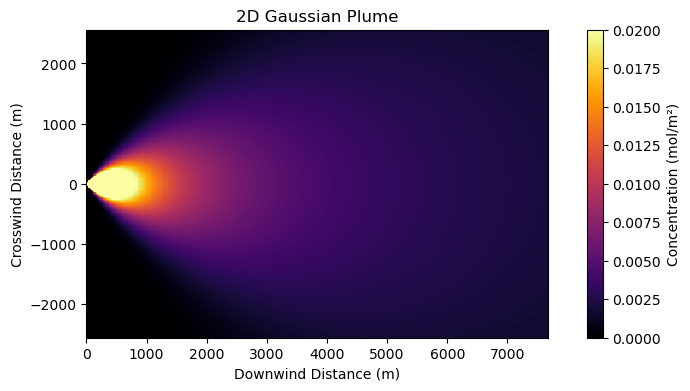

In [2]:
# Grid parameters
nx, ny = 384, 256  # grid dimensions
dx = 20  # pixel resolution in meters
wind_speed = 8.0  # m/s

# Create coordinate grid
x = np.linspace(0, nx * dx, nx)
y = np.linspace(-ny * dx / 2, ny * dx / 2, ny)
X, Y = np.meshgrid(x, y)

# time taken to travel downwind
time_x = X / wind_speed
# crosswind diffusion coefficient as a function of time
lateral_dispersion_coefficient = 4  # (m/s)
sigma_y = lateral_dispersion_coefficient * time_x + 0.0001  # (m)

# Source parameters
Q = 500.0  # emission rate (kg/hr)

# see src/utils/quantification_utils.py for conversion factor
kg_per_hr_to_mol_per_s = 57.75286  # (kg/hr) per (mol/s)
methane_per_pixel_slice = Q / wind_speed * nx / kg_per_hr_to_mol_per_s  # (mol)

source_x = dx * 10  # source location (m)
source_y = 0.0  # source location (m)

# Calculate concentration field (2D)
normalized_dispersion = special.ndtr(((Y + dx / 2) - source_y) / sigma_y) - special.ndtr(
    ((Y - dx / 2) - source_y) / sigma_y
)  # (unitless)


# Convert total methane per slice to concentration (mol/m^2)
concentration = normalized_dispersion * methane_per_pixel_slice / (dx * dx)  # (mol/m^2)

# Plot the result
plt.figure(figsize=(10, 4))
plt.imshow(
    concentration,
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    origin="lower",
    vmax=0.02,
    interpolation="nearest",
    cmap="inferno",
)
plt.colorbar(label="Concentration (mol/m²)")
plt.xlabel("Downwind Distance (m)")
plt.ylabel("Crosswind Distance (m)")
plt.title("2D Gaussian Plume")

In [3]:
from io import StringIO

import pandas as pd

data_io = StringIO("""2024-12-26 14:28:00 -2.973735   1.782069
2024-12-26 14:28:05 -2.814748   2.297844
2024-12-26 14:28:10 -2.899173   2.02873
2024-12-26 14:28:15 -3.026608   2.27503
2024-12-26 14:28:20 -2.962244   2.154915
2024-12-26 14:28:25 -3.00483    2.190524
2024-12-26 14:28:30 -3.412472   1.766363
2024-12-26 14:28:35 -3.23972    2.129901
2024-12-26 14:28:40 -2.910658   2.032665
2024-12-26 14:28:45 -3.446095   2.20874
2024-12-26 14:28:50 -2.62506    2.212812
2024-12-26 14:28:55 -3.026076   1.943219
2024-12-26 14:29:00 -2.879379   2.005375
2024-12-26 14:29:05 -3.029976   1.594714
2024-12-26 14:29:10 -2.590792   2.42074
2024-12-26 14:29:15 -2.869476   2.152292
2024-12-26 14:29:20 -2.794311   2.065134
2024-12-26 14:29:25 -2.859272   1.643195
2024-12-26 14:29:30 -2.891475   2.127457
2024-12-26 14:29:35 -2.802921   1.982439
2024-12-26 14:29:40 -2.775993   1.638114
2024-12-26 14:29:45 -2.492819   1.658458
2024-12-26 14:29:50 -2.843093   2.060706
2024-12-26 14:29:55 -3.041784   2.114165
2024-12-26 14:30:00 -3.062332   1.620465
2024-12-26 14:30:05 -2.795244   1.612006
2024-12-26 14:30:10 -2.597391   1.747285
2024-12-26 14:30:15 -3.290928   2.259032
2024-12-26 14:30:20 -2.99525    1.72276
2024-12-26 14:30:25 -2.506938   1.976623
2024-12-26 14:30:30 -2.589049   2.380193
2024-12-26 14:30:35 -2.880801   1.916609
2024-12-26 14:30:40 -2.865736   1.979812
2024-12-26 14:30:45 -2.807227   1.767755
2024-12-26 14:30:50 -2.890012   1.970073
2024-12-26 14:30:55 -2.585181   1.957554
2024-12-26 14:31:00 -2.989568   2.219459
2024-12-26 14:31:05 -2.679309   1.640518
2024-12-26 14:31:10 -3.125754   1.880689
2024-12-26 14:31:15 -2.936713   2.23283
2024-12-26 14:31:20 -2.516605   1.96955
2024-12-26 14:31:25 -2.91906    2.248682
2024-12-26 14:31:30 -3.015691   2.005435
2024-12-26 14:31:35 -2.690311   1.791926
2024-12-26 14:31:40 -2.628745   1.897798
2024-12-26 14:31:45 -3.239403   1.811692
2024-12-26 14:31:50 -2.998819   2.01113
2024-12-26 14:31:55 -2.878885   1.853116
2024-12-26 14:32:00 -2.993725   1.588989
2024-12-26 14:32:05 -3.076765   1.472059
2024-12-26 14:32:10 -2.665421   1.641921
2024-12-26 14:32:15 -2.998049   1.914802
2024-12-26 14:32:20 -2.322982   1.525342
2024-12-26 14:32:25 -2.598269   1.515838
2024-12-26 14:32:30 -2.385874   1.215177
2024-12-26 14:32:35 -2.018699   1.119422
2024-12-26 14:32:40 -2.763394   1.503227
2024-12-26 14:32:45 -2.595406   1.928348
2024-12-26 14:32:50 -2.345427   1.670503
2024-12-26 14:32:55 -2.549917   1.784938
2024-12-26 14:33:00 -2.565521   1.548142
2024-12-26 14:33:05 -2.656537   1.509429
2024-12-26 14:33:10 -2.393828   1.611704
2024-12-26 14:33:15 -2.529123   1.319826
2024-12-26 14:33:20 -2.595127   1.465467
2024-12-26 14:33:25 -2.845302   1.526028
2024-12-26 14:33:30 -3.10675    1.646646
2024-12-26 14:33:35 -2.517808   1.337848
2024-12-26 14:33:40 -2.532157   1.546427
2024-12-26 14:33:45 -2.544345   1.266452
2024-12-26 14:33:50 -2.857579   1.49207
2024-12-26 14:33:55 -2.750349   1.801013
2024-12-26 14:34:00 -3.020782   1.269142
2024-12-26 14:34:05 -2.716452   1.443069
2024-12-26 14:34:10 -2.638518   0.9716442
2024-12-26 14:34:15 -2.48004    1.185888
2024-12-26 14:34:20 -2.492256   1.189064
2024-12-26 14:34:25 -2.39156    1.075217
2024-12-26 14:34:30 -3.181507   1.67431
2024-12-26 14:34:35 -2.224515   1.586603
2024-12-26 14:34:40 -2.636311   1.196778
2024-12-26 14:34:45 -2.428897   1.186047
2024-12-26 14:34:50 -2.292663   1.566838
2024-12-26 14:34:55 -2.356791   1.453371
2024-12-26 14:35:00 -2.232257   0.946909
2024-12-26 14:35:05 -2.33217    1.3567
2024-12-26 14:35:10 -2.468882   0.7586381
2024-12-26 14:35:15 -2.242716   0.9618765
2024-12-26 14:35:20 -1.789169   0.8883032
2024-12-26 14:35:25 -2.068927   0.5407773
2024-12-26 14:35:30 -2.207685   0.8167799
2024-12-26 14:35:35 -2.125616   0.8914204
2024-12-26 14:35:40 -2.044924   0.9907272
2024-12-26 14:35:45 -2.198982   0.8824029
2024-12-26 14:35:50 -2.196047   0.7445527
2024-12-26 14:35:55 -2.270753   0.8276138
2024-12-26 14:36:00 -2.169267   0.7671353
2024-12-26 14:36:05 -2.018876   0.7079859
2024-12-26 14:36:10 -1.981964   0.8961353
2024-12-26 14:36:15 -2.442691   0.5753551
2024-12-26 14:36:20 -1.955536   0.6515495
2024-12-26 14:36:25 -2.048  0.7520248
2024-12-26 14:36:30 -2.266839   0.9018329
2024-12-26 14:36:35 -1.986078   0.8293976
2024-12-26 14:36:40 -1.914664   0.731146
2024-12-26 14:36:45 -1.843865   0.6032335
2024-12-26 14:36:50 -1.841477   0.5087968
2024-12-26 14:36:55 -1.907928   0.6675991
2024-12-26 14:37:00 -2.120349   0.8564679
2024-12-26 14:37:05 -2.113303   0.5726377
2024-12-26 14:37:10 -1.998677   0.6227637
2024-12-26 14:37:15 -1.78276    0.6021762
2024-12-26 14:37:20 -2.128356   0.6448408
2024-12-26 14:37:25 -2.18822    0.7189516
2024-12-26 14:37:30 -1.71932    0.6471864
2024-12-26 14:37:35 -2.14551    0.6553576
2024-12-26 14:37:40 -1.893721   0.4917333
2024-12-26 14:37:45 -2.004629   0.6920164
2024-12-26 14:37:50 -1.849272   0.4946263
2024-12-26 14:37:55 -1.910074   0.7257517
2024-12-26 14:38:00 -2.10044    0.4942672
2024-12-26 14:38:05 -1.906322   0.7060562
2024-12-26 14:38:10 -1.990854   0.6268213
2024-12-26 14:38:15 -1.912227   0.8062081
2024-12-26 14:38:20 -2.12754    0.8161564
2024-12-26 14:38:25 -2.02584    1.165054
2024-12-26 14:38:30 -1.759686   0.7817703
2024-12-26 14:38:35 -1.437659   0.632561
2024-12-26 14:38:40 -1.91741    0.9106231
2024-12-26 14:38:45 -1.693416   0.9917987
2024-12-26 14:38:50 -1.890022   0.9576726
2024-12-26 14:38:55 -1.869807   0.9608286
2024-12-26 14:39:00 -1.777672   0.8736723
2024-12-26 14:39:05 -1.874901   0.9712024
2024-12-26 14:39:10 -1.842721   0.6473297
2024-12-26 14:39:15 -1.816002   0.8872021
2024-12-26 14:39:20 -1.831596   0.8127456
2024-12-26 14:39:25 -1.729638   0.9735896
2024-12-26 14:39:30 -1.799536   0.8605459
2024-12-26 14:39:35 -2.013411   0.9158145
2024-12-26 14:39:40 -1.88414    1.126962
2024-12-26 14:39:45 -1.965025   1.169182
2024-12-26 14:39:50 -2.027591   1.225397
2024-12-26 14:39:55 -1.494531   1.07968
2024-12-26 14:40:00 -1.836809   1.09998
2024-12-26 14:40:05 -2.023133   1.100496
2024-12-26 14:40:10 -2.028852   1.338494
2024-12-26 14:40:15 -1.938386   1.291695
2024-12-26 14:40:20 -2.153486   1.441717
2024-12-26 14:40:25 -1.873594   1.372058
2024-12-26 14:40:30 -1.96226    1.300509
2024-12-26 14:40:35 -1.96753    1.442119
2024-12-26 14:40:40 -2.047649   1.447847
2024-12-26 14:40:45 -1.959159   1.635902
2024-12-26 14:40:50 -2.095534   1.504466
2024-12-26 14:40:55 -1.895517   1.473599
2024-12-26 14:41:00 -1.817255   1.483928
2024-12-26 14:41:05 -2.017303   1.547461
2024-12-26 14:41:10 -1.91621    1.646332
2024-12-26 14:41:15 -1.847148   1.629375
2024-12-26 14:41:20 -1.968071   1.648167
2024-12-26 14:41:25 -2.016417   1.615735
2024-12-26 14:41:30 -1.933522   1.551848
2024-12-26 14:41:35 -1.998876   1.810402
2024-12-26 14:41:40 -1.845849   1.629803
2024-12-26 14:41:45 -1.766055   1.632538
2024-12-26 14:41:50 -1.648275   1.554276
2024-12-26 14:41:55 -1.871874   1.619661
2024-12-26 14:42:00 -1.66503    1.69039
2024-12-26 14:42:05 -1.918257   1.625234
2024-12-26 14:42:10 -1.990312   1.619281
2024-12-26 14:42:15 -1.902262   1.803961
2024-12-26 14:42:20 -2.058432   1.693355
2024-12-26 14:42:25 -1.887861   1.791316
2024-12-26 14:42:30 -1.997513   1.77135
2024-12-26 14:42:35 -2.017337   1.597246
2024-12-26 14:42:40 -1.986585   1.732312
2024-12-26 14:42:45 -1.939008   1.772661
2024-12-26 14:42:50 -2.039691   1.641084
2024-12-26 14:42:55 -1.67872    1.556548
2024-12-26 14:43:00 -2.076917   1.665609
2024-12-26 14:43:05 -2.15848    1.833844
2024-12-26 14:43:10 -2.118807   1.568721
2024-12-26 14:43:15 -1.833223   1.662374
2024-12-26 14:43:20 -2.027021   1.622112
2024-12-26 14:43:25 -2.073079   1.532028
2024-12-26 14:43:30 -2.07681    1.669246
2024-12-26 14:43:35 -2.114467   1.824908
2024-12-26 14:43:40 -1.725608   1.492552
2024-12-26 14:43:45 -2.111322   1.663816
2024-12-26 14:43:50 -2.001223   1.448785
2024-12-26 14:43:55 -1.98788    1.707425
2024-12-26 14:44:00 -1.869349   1.617324
2024-12-26 14:44:05 -1.829847   1.379755
2024-12-26 14:44:10 -1.978281   1.198866
2024-12-26 14:44:15 -1.604267   1.540151
2024-12-26 14:44:20 -1.938639   1.226226
2024-12-26 14:44:25 -2.047117   1.481589
2024-12-26 14:44:30 -1.783421   1.442489
2024-12-26 14:44:35 -1.906344   1.749285
2024-12-26 14:44:40 -1.970818   1.544867
2024-12-26 14:44:45 -1.955254   1.707559
2024-12-26 14:44:50 -2.021246   1.769714
2024-12-26 14:44:55 -1.756302   1.756889
2024-12-26 14:45:00 -1.775023   1.583634
2024-12-26 14:45:05 -1.968987   1.64246
2024-12-26 14:45:10 -1.523832   1.40584
2024-12-26 14:45:15 -1.564376   1.398274
2024-12-26 14:45:20 -1.796223   1.463793
2024-12-26 14:45:25 -2.143135   1.672632
2024-12-26 14:45:30 -1.703299   1.307698
2024-12-26 14:45:35 -1.59458    1.624962
2024-12-26 14:45:40 -1.520109   1.673502
2024-12-26 14:45:45 -1.663048   1.504407
2024-12-26 14:45:50 -1.60034    1.760715
2024-12-26 14:45:55 -1.369997   1.394704
2024-12-26 14:46:00 -1.395165   1.474049
2024-12-26 14:46:05 -1.525693   1.368892
2024-12-26 14:46:10 -1.665855   1.135042
2024-12-26 14:46:15 -1.650114   1.413126
2024-12-26 14:46:20 -1.319404   1.630469
2024-12-26 14:46:25 -1.340143   1.407553
2024-12-26 14:46:30 -1.358347   1.455432
2024-12-26 14:46:35 -1.382513   1.297313
2024-12-26 14:46:40 -1.192754   1.41576
2024-12-26 14:46:45 -1.296  1.641191
2024-12-26 14:46:50 -1.477571   1.695858
2024-12-26 14:46:55 -1.385483   1.646566
2024-12-26 14:47:00 -1.371199   1.4251
2024-12-26 14:47:05 -1.544088   1.578234
2024-12-26 14:47:10 -0.9049013  1.084907
2024-12-26 14:47:15 -1.49717    1.459263
2024-12-26 14:47:20 -1.134229   1.268804
2024-12-26 14:47:25 -1.406407   1.307132
2024-12-26 14:47:30 -1.494288   1.440653
2024-12-26 14:47:35 -1.741333   1.472138
2024-12-26 14:47:40 -1.44478    1.401264
2024-12-26 14:47:45 -1.525332   1.463559
2024-12-26 14:47:50 -1.614981   1.249734
2024-12-26 14:47:55 -1.389401   1.36905
2024-12-26 14:48:00 -1.435106   1.216455
2024-12-26 14:48:05 -1.476816   1.186671
2024-12-26 14:48:10 -1.588286   1.255567
2024-12-26 14:48:15 -1.835128   1.392716
2024-12-26 14:48:20 -1.54639    1.385785
2024-12-26 14:48:25 -1.598331   1.018672
2024-12-26 14:48:30 -1.694996   1.328583
2024-12-26 14:48:35 -1.822658   1.522784
2024-12-26 14:48:40 -1.732443   1.537252
2024-12-26 14:48:45 -1.855415   1.307527
2024-12-26 14:48:50 -1.811499   1.401059
2024-12-26 14:48:55 -1.835531   1.535117
2024-12-26 14:49:00 -1.982156   1.431243
2024-12-26 14:49:05 -1.99184    1.706592
2024-12-26 14:49:10 -1.86132    1.423368
2024-12-26 14:49:15 -2.065156   1.695579
2024-12-26 14:49:20 -1.97528    1.374496
2024-12-26 14:49:25 -1.936198   1.503595
2024-12-26 14:49:30 -1.950503   1.732778
2024-12-26 14:49:35 -1.948644   1.381521
2024-12-26 14:49:40 -1.751811   1.361127
2024-12-26 14:49:45 -1.749331   1.636379
2024-12-26 14:49:50 -2.158471   1.722562
2024-12-26 14:49:55 -2.193725   1.721645
2024-12-26 14:50:00 -2.094412   1.765142
2024-12-26 14:50:05 -2.461625   1.543516
2024-12-26 14:50:10 -2.029249   1.642244
2024-12-26 14:50:15 -2.097432   1.826006
2024-12-26 14:50:20 -2.175668   1.867815
2024-12-26 14:50:25 -2.345188   1.728727
2024-12-26 14:50:30 -2.107578   1.632648
2024-12-26 14:50:35 -2.066266   1.591934
2024-12-26 14:50:40 -2.448535   1.900164
2024-12-26 14:50:45 -2.413286   1.888744
2024-12-26 14:50:50 -2.410439   1.936283
2024-12-26 14:50:55 -2.190459   2.038038
2024-12-26 14:51:00 -2.41747    1.90394
2024-12-26 14:51:05 -2.298179   1.836798
2024-12-26 14:51:10 -2.24653    1.982924
2024-12-26 14:51:15 -2.193185   1.944238
2024-12-26 14:51:20 -1.586819   1.618179
2024-12-26 14:51:25 -1.9014 1.915597
2024-12-26 14:51:30 -2.054635   2.026833
2024-12-26 14:51:35 -2.07259    1.628286
2024-12-26 14:51:40 -2.281961   1.891748
2024-12-26 14:51:45 -2.254477   1.962082
2024-12-26 14:51:50 -2.073599   1.663792
2024-12-26 14:51:55 -2.35602    1.766052
2024-12-26 14:52:00 -2.118143   1.771602
2024-12-26 14:52:05 -2.417649   1.944818
2024-12-26 14:52:10 -2.45725    1.955296
2024-12-26 14:52:15 -2.505912   1.955552
2024-12-26 14:52:20 -2.530846   2.035737
2024-12-26 14:52:25 -2.45979    2.156057
2024-12-26 14:52:30 -2.283766   2.012365
2024-12-26 14:52:35 -2.161657   2.180752
2024-12-26 14:52:40 -2.181325   1.975605
2024-12-26 14:52:45 -2.293577   2.078934
2024-12-26 14:52:50 -2.403408   1.990726
2024-12-26 14:52:55 -2.245617   2.208377
2024-12-26 14:53:00 -2.086939   2.104178
2024-12-26 14:53:05 -2.262388   2.135324
2024-12-26 14:53:10 -2.080054   2.112473
2024-12-26 14:53:15 -1.972772   2.08324
2024-12-26 14:53:20 -1.911136   2.133817
2024-12-26 14:53:25 -2.179525   2.001562
2024-12-26 14:53:30 -1.90699    2.063667
2024-12-26 14:53:35 -1.918364   1.898535
2024-12-26 14:53:40 -1.883191   1.946146
2024-12-26 14:53:45 -2.184885   2.283231
2024-12-26 14:53:50 -1.743255   2.039919
2024-12-26 14:53:55 -2.29221    2.265532
2024-12-26 14:54:00 -2.139294   1.866538
2024-12-26 14:54:05 -1.957172   1.485103
2024-12-26 14:54:10 -1.986976   1.703488
2024-12-26 14:54:15 -2.009041   2.061439
2024-12-26 14:54:20 -1.275484   1.797923
2024-12-26 14:54:25 -1.927585   1.966634
2024-12-26 14:54:30 -2.126448   1.987198
2024-12-26 14:54:35 -1.9033 1.993449
2024-12-26 14:54:40 -2.140481   2.230609
2024-12-26 14:54:45 -2.001555   1.89229
2024-12-26 14:54:50 -1.916976   2.060656
2024-12-26 14:54:55 -1.971023   1.990783
2024-12-26 14:55:00 -1.993449   2.032761
2024-12-26 14:55:05 -1.932985   2.00424
2024-12-26 14:55:10 -2.190319   1.894533
2024-12-26 14:55:15 -1.946164   1.680022
2024-12-26 14:55:20 -2.258893   2.058245
2024-12-26 14:55:25 -1.803076   1.949175
2024-12-26 14:55:30 -1.866859   1.989079
2024-12-26 14:55:35 -1.889993   1.865584
2024-12-26 14:55:40 -1.97172    1.832059
2024-12-26 14:55:45 -2.040747   1.954301
2024-12-26 14:55:50 -1.581375   1.741443
2024-12-26 14:55:55 -1.997731   1.61869
2024-12-26 14:56:00 -1.943264   2.116398
2024-12-26 14:56:05 -1.58297    1.841156
2024-12-26 14:56:10 -1.374968   1.67116
2024-12-26 14:56:15 -1.55376    0.9994181
2024-12-26 14:56:20 -2.054674   1.905901
2024-12-26 14:56:25 -2.20517    1.654292
2024-12-26 14:56:30 -1.900188   1.840503
2024-12-26 14:56:35 -1.84735    1.504599
2024-12-26 14:56:40 -1.711993   1.769411
2024-12-26 14:56:45 -1.794255   1.883957
2024-12-26 14:56:50 -1.532552   1.882721
2024-12-26 14:56:55 -1.467599   1.635951
2024-12-26 14:57:00 -1.802104   2.133293
2024-12-26 14:57:05 -1.838789   1.905056
2024-12-26 14:57:10 -1.551381   1.704662
2024-12-26 14:57:15 -1.314291   1.890252
2024-12-26 14:57:20 -1.865354   2.736173
2024-12-26 14:57:25 -1.378532   1.861217
2024-12-26 14:57:30 -2.127481   2.260146
2024-12-26 14:57:35 -1.535204   2.184571
2024-12-26 14:57:40 -2.177726   2.03037
2024-12-26 14:57:45 -1.803767   2.015037
2024-12-26 14:57:50 -2.080009   2.402534
2024-12-26 14:57:55 -2.121943   1.599081
2024-12-26 14:58:00 -1.327142   1.601298
2024-12-26 14:58:05 -2.034746   2.272343
2024-12-26 14:58:10 -2.104428   1.292247
2024-12-26 14:58:15 -1.952869   2.050223
2024-12-26 14:58:20 -1.873621   2.440616
2024-12-26 14:58:25 -1.382427   2.039075
2024-12-26 14:58:30 -1.788134   1.935941
2024-12-26 14:58:35 -1.913039   2.271199
2024-12-26 14:58:40 -2.03165    1.766489
2024-12-26 14:58:45 -1.389573   1.651814
2024-12-26 14:58:50 -1.182598   1.457114
2024-12-26 14:58:55 -1.843748   1.688949
2024-12-26 14:59:00 -1.279678   1.914641
2024-12-26 14:59:05 -1.745918   1.878397
2024-12-26 14:59:10 -1.910767   1.858267
2024-12-26 14:59:15 -1.765654   2.17611
2024-12-26 14:59:20 -2.217685   2.132811
2024-12-26 14:59:25 -2.121792   2.395138
2024-12-26 14:59:30 -2.50397    2.334772
2024-12-26 14:59:35 -2.472341   2.252699
2024-12-26 14:59:40 -2.036922   2.135322
2024-12-26 14:59:45 -2.198337   1.891463
2024-12-26 14:59:50 -2.301724   2.277103
2024-12-26 14:59:55 -1.724527   2.419028
2024-12-26 15:00:00 -1.590674   2.821298
2024-12-26 15:00:05 -1.830831   2.426508
2024-12-26 15:00:10 -1.823066   1.914993
2024-12-26 15:00:15 -1.715512   2.078471
2024-12-26 15:00:20 -1.622995   1.987904
2024-12-26 15:00:25 -1.985692   2.059367
2024-12-26 15:00:30 -2.303489   1.623352
2024-12-26 15:00:35 -2.063481   2.572036
2024-12-26 15:00:40 -2.167034   2.612261
2024-12-26 15:00:45 -2.035523   2.187007
2024-12-26 15:00:50 -2.013602   2.148704
2024-12-26 15:00:55 -2.318976   2.190477
2024-12-26 15:01:00 -2.21075    2.461072
2024-12-26 15:01:05 -2.251498   2.164481
2024-12-26 15:01:10 -2.524614   2.27594
2024-12-26 15:01:15 -2.688496   2.430181
2024-12-26 15:01:20 -2.51051    1.661805
2024-12-26 15:01:25 -3.022811   2.70958
2024-12-26 15:01:30 -2.756105   1.957826
2024-12-26 15:01:35 -2.111196   2.572743
2024-12-26 15:01:40 -2.791921   2.404459
2024-12-26 15:01:45 -2.189951   2.54005
2024-12-26 15:01:50 -2.27177    2.217824
2024-12-26 15:01:55 -2.596719   1.536212
2024-12-26 15:02:00 -2.626146   2.068258
2024-12-26 15:02:05 -1.982039   1.965214
2024-12-26 15:02:10 -2.230219   2.258013
2024-12-26 15:02:15 -2.320812   2.677169
2024-12-26 15:02:20 -2.323987   2.249474
2024-12-26 15:02:25 -2.529244   2.395686
2024-12-26 15:02:30 -2.333173   2.450632
2024-12-26 15:02:35 -2.474101   2.835066
2024-12-26 15:02:40 -2.955254   2.095487
2024-12-26 15:02:45 -3.243205   2.201923
2024-12-26 15:02:50 -2.801115   2.304178
2024-12-26 15:02:55 -1.207354   2.693252
2024-12-26 15:03:00 -1.253691   2.896048
2024-12-26 15:03:05 -2.342398   1.733734
2024-12-26 15:03:10 -2.540318   2.474206
2024-12-26 15:03:15 -2.06943    1.598734
2024-12-26 15:03:20 -2.603395   2.00307
2024-12-26 15:03:25 -2.216301   2.539845
2024-12-26 15:03:30 -2.877666   2.297018
2024-12-26 15:03:35 -2.475485   2.576495
2024-12-26 15:03:40 -2.205674   2.364899
2024-12-26 15:03:45 -2.441352   2.233371
2024-12-26 15:03:50 -2.275286   2.422267
2024-12-26 15:03:55 -2.140319   2.166098
2024-12-26 15:04:00 -2.336712   1.725203
2024-12-26 15:04:05 -2.445154   2.457826
2024-12-26 15:04:10 -2.687828   2.277567
2024-12-26 15:04:15 -2.563081   2.04668
2024-12-26 15:04:20 -2.435743   1.685503
2024-12-26 15:04:25 -2.220296   1.989144
2024-12-26 15:04:30 -2.335932   1.977431
2024-12-26 15:04:35 -2.236514   1.976164
2024-12-26 15:04:40 -2.194853   1.659037
2024-12-26 15:04:45 -2.126364   2.576448
2024-12-26 15:04:50 -2.528242   2.238837
2024-12-26 15:04:55 -2.753814   2.815821
2024-12-26 15:05:00 -2.459759   2.525103
2024-12-26 15:05:05 -2.277051   1.809323
2024-12-26 15:05:10 -2.318174   2.452187
2024-12-26 15:05:15 -2.625808   2.233907
2024-12-26 15:05:20 -2.518337   2.433143
2024-12-26 15:05:25 -2.07365    2.519339
2024-12-26 15:05:30 -2.431748   2.575799
2024-12-26 15:05:35 -2.552862   2.311626
2024-12-26 15:05:40 -2.197003   2.614918
2024-12-26 15:05:45 -1.959738   2.185179
2024-12-26 15:05:50 -2.14153    2.567347
2024-12-26 15:05:55 -2.61036    2.97244
2024-12-26 15:06:00 -2.724298   2.700809
2024-12-26 15:06:05 -2.473659   2.626192
2024-12-26 15:06:10 -2.648994   2.44976
2024-12-26 15:06:15 -2.691123   2.530912
2024-12-26 15:06:20 -2.49237    2.419145
2024-12-26 15:06:25 -2.758473   2.246031
2024-12-26 15:06:30 -1.490812   2.117156
2024-12-26 15:06:35 -1.704236   1.904711
2024-12-26 15:06:40 -2.305434   1.693711
2024-12-26 15:06:45 -1.452724   1.996111
2024-12-26 15:06:50 -1.677022   2.433559
2024-12-26 15:06:55 -2.178793   3.14269
2024-12-26 15:07:00 -2.558798   2.605455
2024-12-26 15:07:05 -2.256997   2.608514
2024-12-26 15:07:10 -2.031137   2.936784
2024-12-26 15:07:15 -3.047544   2.579063
2024-12-26 15:07:20 -2.403609   2.692363
2024-12-26 15:07:25 -2.163917   2.638821
2024-12-26 15:07:30 -1.934291   2.514096
2024-12-26 15:07:35 -2.371097   2.462318
2024-12-26 15:07:40 -2.294469   2.634809
2024-12-26 15:07:45 -1.569712   2.318812
2024-12-26 15:07:50 -1.930483   2.12267
2024-12-26 15:07:55 -2.050023   1.920287
2024-12-26 15:08:00 -1.347498   1.97255
2024-12-26 15:08:05 -1.272409   1.805706
2024-12-26 15:08:10 -1.773272   1.873982
2024-12-26 15:08:15 -1.741777   2.11648
2024-12-26 15:08:20 -1.422385   1.748899
2024-12-26 15:08:25 -1.522338   3.275946
2024-12-26 15:08:30 -2.2855 2.038016
2024-12-26 15:08:35 -2.263367   2.60161
2024-12-26 15:08:40 -1.786019   2.267563
2024-12-26 15:08:45 -2.314823   2.612925
2024-12-26 15:08:50 -1.544107   2.627982
2024-12-26 15:08:55 -1.819654   2.456669
2024-12-26 15:09:00 -1.105264   2.239286
2024-12-26 15:09:05 -1.523288   2.237821
2024-12-26 15:09:10 -2.132919   2.554201
2024-12-26 15:09:15 -1.861581   2.693469
2024-12-26 15:09:20 -1.87816    3.085583
2024-12-26 15:09:25 -1.925146   2.746462
2024-12-26 15:09:30 -1.235407   2.515664
2024-12-26 15:09:35 -2.315266   2.387753
2024-12-26 15:09:40 -2.065757   2.993679
2024-12-26 15:09:45 -2.314917   2.81922
2024-12-26 15:09:50 -2.126272   2.652863
2024-12-26 15:09:55 -1.692124   2.391418
2024-12-26 15:10:00 -1.697027   2.191458
2024-12-26 15:10:05 -2.020182   2.832366
2024-12-26 15:10:10 -1.701047   2.490408
2024-12-26 15:10:15 -1.961534   2.277935
2024-12-26 15:10:20 -1.83673    2.544287
2024-12-26 15:10:25 -2.271537   2.401468
2024-12-26 15:10:30 -1.840955   2.336454
2024-12-26 15:10:35 -1.525855   2.213546
2024-12-26 15:10:40 -1.933746   2.425803
2024-12-26 15:10:45 -2.019345   2.194319
2024-12-26 15:10:50 -2.756889   2.051189
2024-12-26 15:10:55 -1.447748   1.536872
2024-12-26 15:11:00 -1.925947   2.296356
2024-12-26 15:11:05 -1.582175   2.163877
2024-12-26 15:11:10 -2.059407   2.256885
2024-12-26 15:11:15 -1.917059   2.329789
2024-12-26 15:11:20 -1.825547   1.780689
2024-12-26 15:11:25 -2.215849   2.584689
2024-12-26 15:11:30 -2.430691   2.260919
2024-12-26 15:11:35 -1.999228   2.351055
2024-12-26 15:11:40 -2.560344   2.648055
2024-12-26 15:11:45 -2.897344   2.635042
2024-12-26 15:11:50 -2.977665   2.239902
2024-12-26 15:11:55 -2.776572   2.504439
2024-12-26 15:12:00 -2.606166   3.04307
2024-12-26 15:12:05 -2.555779   2.569678
2024-12-26 15:12:10 -2.551379   2.648165
2024-12-26 15:12:15 -1.98719    3.029382
2024-12-26 15:12:20 -2.75133    2.892204
2024-12-26 15:12:25 -2.144522   3.019584
2024-12-26 15:12:30 -2.587523   2.721458
2024-12-26 15:12:35 -2.442425   2.743907
2024-12-26 15:12:40 -2.53017    3.087782
2024-12-26 15:12:45 -2.588855   2.886269
2024-12-26 15:12:50 -2.625276   3.201579
2024-12-26 15:12:55 -2.687825   2.889002
2024-12-26 15:13:00 -2.945046   2.137748
2024-12-26 15:13:05 -2.437915   2.484615
2024-12-26 15:13:10 -2.77436    2.68824
2024-12-26 15:13:15 -2.274059   2.749632
2024-12-26 15:13:20 -2.319658   2.585346
2024-12-26 15:13:25 -2.722895   2.738712
2024-12-26 15:13:30 -2.180369   3.079682
2024-12-26 15:13:35 -2.491158   2.282082
2024-12-26 15:13:40 -2.518268   2.672903
2024-12-26 15:13:45 -2.167215   2.893391
2024-12-26 15:13:50 -2.879595   2.973667
2024-12-26 15:13:55 -3.040917   2.697855
2024-12-26 15:14:00 -3.156503   3.101546
2024-12-26 15:14:05 -2.82304    2.717038
2024-12-26 15:14:10 -2.674696   2.618884
2024-12-26 15:14:15 -2.895906   2.87078
2024-12-26 15:14:20 -2.687972   2.933101
2024-12-26 15:14:25 -2.335449   2.754669
2024-12-26 15:14:30 -2.337487   3.068694
2024-12-26 15:14:35 -2.414103   3.057881
2024-12-26 15:14:40 -2.813231   2.535607
2024-12-26 15:14:45 -2.719651   2.8844
2024-12-26 15:14:50 -2.678585   2.258048
2024-12-26 15:14:55 -2.920793   3.715336
2024-12-26 15:15:00 -3.315617   2.872357
2024-12-26 15:15:05 -3.140473   2.602679
2024-12-26 15:15:10 -3.293002   3.339011
2024-12-26 15:15:15 -2.724726   2.901705
2024-12-26 15:15:20 -2.645792   2.750866
2024-12-26 15:15:25 -2.067682   1.845311
2024-12-26 15:15:30 -2.60597    2.382276
2024-12-26 15:15:35 -2.981583   2.822712
2024-12-26 15:15:40 -2.902777   2.953754
2024-12-26 15:15:45 -2.576302   2.259956
2024-12-26 15:15:50 -2.655326   2.434197
2024-12-26 15:15:55 -1.714473   2.277635
2024-12-26 15:16:00 -3.18818    3.142683
2024-12-26 15:16:05 -2.031588   2.83787
2024-12-26 15:16:10 -2.344374   3.261769
2024-12-26 15:16:15 -2.736985   2.815565
2024-12-26 15:16:20 -2.39076    2.874662
2024-12-26 15:16:25 -2.610388   3.140529
2024-12-26 15:16:30 -2.570393   2.994794
2024-12-26 15:16:35 -2.698252   3.183948
2024-12-26 15:16:40 -2.476026   2.819288
2024-12-26 15:16:45 -2.268821   2.735031
2024-12-26 15:16:50 -2.71128    3.132756
2024-12-26 15:16:55 -2.576928   3.397111
2024-12-26 15:17:00 -2.728244   2.773927
2024-12-26 15:17:05 -1.871741   2.807823
2024-12-26 15:17:10 -1.69111    3.233212
2024-12-26 15:17:15 -2.079573   2.540117
2024-12-26 15:17:20 -1.809063   2.327525
2024-12-26 15:17:25 -2.396729   2.28378
2024-12-26 15:17:30 -1.454141   2.286421
2024-12-26 15:17:35 -2.075835   2.918644
2024-12-26 15:17:40 -2.178059   1.629335
2024-12-26 15:17:45 -2.046095   2.163486
2024-12-26 15:17:50 -1.555182   2.964746
2024-12-26 15:17:55 -2.090283   2.379783
2024-12-26 15:18:00 -1.565006   2.485012
2024-12-26 15:18:05 -1.825892   2.561472
2024-12-26 15:18:10 -2.715266   3.004961
2024-12-26 15:18:15 -2.036836   3.21969
2024-12-26 15:18:20 -2.283122   2.484791
2024-12-26 15:18:25 -2.148902   2.591434
2024-12-26 15:18:30 -2.258673   2.94327
2024-12-26 15:18:35 -2.112694   2.284298
2024-12-26 15:18:40 -2.088231   2.389992
2024-12-26 15:18:45 -2.368374   2.548309
2024-12-26 15:18:50 -2.44087    3.034206
2024-12-26 15:18:55 -2.344088   1.987444
2024-12-26 15:19:00 -2.730653   3.124848
2024-12-26 15:19:05 -2.953341   2.804503
2024-12-26 15:19:10 -2.041417   2.687911
2024-12-26 15:19:15 -1.764673   2.272239
2024-12-26 15:19:20 -1.632124   2.720825
2024-12-26 15:19:25 -2.764056   2.89313
2024-12-26 15:19:30 -2.179709   2.908539
2024-12-26 15:19:35 -1.317687   2.67505
2024-12-26 15:19:40 -2.047557   2.650244
2024-12-26 15:19:45 -2.065714   2.726808
2024-12-26 15:19:50 -2.098395   2.828761
2024-12-26 15:19:55 -2.003452   2.797272
2024-12-26 15:20:00 -2.393252   2.725989
2024-12-26 15:20:05 -2.137166   3.075629
2024-12-26 15:20:10 -1.53543    2.920266
2024-12-26 15:20:15 -2.850285   2.825401
2024-12-26 15:20:20 -2.438636   2.500213
2024-12-26 15:20:25 -3.095023   3.997985
2024-12-26 15:20:30 -2.042819   2.89595
2024-12-26 15:20:35 -2.913642   3.286708
2024-12-26 15:20:40 -2.821605   3.146108
2024-12-26 15:20:45 -3.547074   3.020281
2024-12-26 15:20:50 -2.580967   2.903074
2024-12-26 15:20:55 -2.288916   1.856831
2024-12-26 15:21:00 -3.051004   2.302789
2024-12-26 15:21:05 -2.255021   3.009762
2024-12-26 15:21:10 -2.239929   2.954376
2024-12-26 15:21:15 -2.381364   2.893545
2024-12-26 15:21:20 -1.375162   3.050361
2024-12-26 15:21:25 -1.712723   2.274117
2024-12-26 15:21:30 -1.678912   2.884884
2024-12-26 15:21:35 -2.568954   1.946714
2024-12-26 15:21:40 -1.991423   2.657141
2024-12-26 15:21:45 -2.018373   2.027402
2024-12-26 15:21:50 -1.909978   2.770324
2024-12-26 15:21:55 -2.056314   1.55954
2024-12-26 15:22:00 -2.621437   1.773069
2024-12-26 15:22:05 -2.967376   2.695465
2024-12-26 15:22:10 -2.467729   2.917192
2024-12-26 15:22:15 -2.431437   2.629243
2024-12-26 15:22:20 -2.314985   3.260477
2024-12-26 15:22:25 -2.032486   3.314139
2024-12-26 15:22:30 -1.741194   3.781869
2024-12-26 15:22:35 -2.002678   3.195226
2024-12-26 15:22:40 -1.262981   3.30869
2024-12-26 15:22:45 -1.609487   3.157472
2024-12-26 15:22:50 -2.789916   3.058253
2024-12-26 15:22:55 -2.076347   2.668544
2024-12-26 15:23:00 -1.801826   3.042991
2024-12-26 15:23:05 -1.807963   2.52011
2024-12-26 15:23:10 -1.731565   2.013969
2024-12-26 15:23:15 -1.873801   2.298406
2024-12-26 15:23:20 -2.031126   1.61374
2024-12-26 15:23:25 -2.498828   2.650838
2024-12-26 15:23:30 -1.634805   2.652074
2024-12-26 15:23:35 -2.479911   2.565989
2024-12-26 15:23:40 -1.648862   2.769797
2024-12-26 15:23:45 -2.193124   2.72661
2024-12-26 15:23:50 -1.802218   3.261899
2024-12-26 15:23:55 -1.985722   2.960509
2024-12-26 15:24:00 -2.088593   2.626951
2024-12-26 15:24:05 -2.22735    2.862586
2024-12-26 15:24:10 -2.552991   3.309783
2024-12-26 15:24:15 -1.712299   3.256399
2024-12-26 15:24:20 -2.394188   3.542891
2024-12-26 15:24:25 -2.330625   3.490694
2024-12-26 15:24:30 -2.112488   3.042163
2024-12-26 15:24:35 -2.070725   2.606046
2024-12-26 15:24:40 -2.100652   2.502655
2024-12-26 15:24:45 -1.742761   2.813478
2024-12-26 15:24:50 -1.581328   3.009224
2024-12-26 15:24:55 -2.07626    3.159111
2024-12-26 15:25:00 -2.004611   2.815366
2024-12-26 15:25:05 -1.676111   2.554299
2024-12-26 15:25:10 -1.693426   3.21251
2024-12-26 15:25:15 -2.231693   2.790537
2024-12-26 15:25:20 -2.649481   3.313969
2024-12-26 15:25:25 -2.981761   3.327258
2024-12-26 15:25:30 -2.329828   3.370535
2024-12-26 15:25:35 -1.877965   3.605494
2024-12-26 15:25:40 -1.899348   3.859591
2024-12-26 15:25:45 -2.041144   3.454129
2024-12-26 15:25:50 -2.000779   3.461507
2024-12-26 15:25:55 -1.96452    2.505311
2024-12-26 15:26:00 -2.674746   3.331902
2024-12-26 15:26:05 -2.090762   4.741904
2024-12-26 15:26:10 -1.884943   2.611713
2024-12-26 15:26:15 -1.997145   2.913036
2024-12-26 15:26:20 -1.724576   3.047414
2024-12-26 15:26:25 -1.581689   3.408604
2024-12-26 15:26:30 -2.431871   2.945584
2024-12-26 15:26:35 -2.46139    2.686353
2024-12-26 15:26:40 -2.080874   2.800485
2024-12-26 15:26:45 -2.77749    3.558127
2024-12-26 15:26:50 -2.058615   2.914041
2024-12-26 15:26:55 -2.326072   2.563197
2024-12-26 15:27:00 -1.743921   2.98306
2024-12-26 15:27:05 -2.36706    2.958576
2024-12-26 15:27:10 -2.179897   2.824889
2024-12-26 15:27:15 -1.778615   2.037832
2024-12-26 15:27:20 -2.165398   2.959217
2024-12-26 15:27:25 -2.391453   2.521259
2024-12-26 15:27:30 -2.749981   2.822415
2024-12-26 15:27:35 -3.47138    3.034769
2024-12-26 15:27:40 -3.171823   2.876782
2024-12-26 15:27:45 -2.229795   3.235539
2024-12-26 15:27:50 -1.61919    2.891771
2024-12-26 15:27:55 -2.293997   2.086854
2024-12-26 15:28:00 -2.371627   3.090779
2024-12-26 15:28:05 -2.547102   3.811804
2024-12-26 15:28:10 -3.202521   3.048283
2024-12-26 15:28:15 -2.13591    3.234061
2024-12-26 15:28:20 -2.130129   3.268203
2024-12-26 15:28:25 -2.736733   3.449788
2024-12-26 15:28:30 -2.404279   3.403121
2024-12-26 15:28:35 -3.387065   2.988121
2024-12-26 15:28:40 -2.288374   2.787537
2024-12-26 15:28:45 -1.99741    3.391882
2024-12-26 15:28:50 -3.67715    2.436134
2024-12-26 15:28:55 -2.335396   3.099309
2024-12-26 15:29:00 -2.818332   2.48757
2024-12-26 15:29:05 -2.098764   3.219394
2024-12-26 15:29:10 -2.083096   3.091556
2024-12-26 15:29:15 -2.448668   2.663423
2024-12-26 15:29:20 -2.193249   2.561827
2024-12-26 15:29:25 -3.006084   2.763572
2024-12-26 15:29:30 -3.263841   1.877265
2024-12-26 15:29:35 -1.481607   2.700624
2024-12-26 15:29:40 -2.058839   2.40131
2024-12-26 15:29:45 -1.950555   2.559793
2024-12-26 15:29:50 -2.531886   2.543734
2024-12-26 15:29:55 -2.498343   2.64491
2024-12-26 15:30:00 -1.810213   2.961899
2024-12-26 15:30:05 -2.630649   3.079226
2024-12-26 15:30:10 -2.631155   2.947776
2024-12-26 15:30:15 -2.199989   3.0723
2024-12-26 15:30:20 -1.599657   3.658898
2024-12-26 15:30:25 -2.65281    2.941145
2024-12-26 15:30:30 -2.194808   3.199532
2024-12-26 15:30:35 -2.743115   2.857761
2024-12-26 15:30:40 -2.041557   2.873538
2024-12-26 15:30:45 -2.330688   3.428352
2024-12-26 15:30:50 -2.11261    2.144299
2024-12-26 15:30:55 -3.052011   2.406191
2024-12-26 15:31:00 -1.365839   2.40376
2024-12-26 15:31:05 -1.954777   2.519844
2024-12-26 15:31:10 -1.675104   1.982961
2024-12-26 15:31:15 -1.257581   1.967839
2024-12-26 15:31:20 -1.482293   2.84416
2024-12-26 15:31:25 -1.776222   3.091223
2024-12-26 15:31:30 -2.344429   1.997396
2024-12-26 15:31:35 -1.897732   2.823277
2024-12-26 15:31:40 -2.295284   2.543761
2024-12-26 15:31:45 -1.786288   3.047764
2024-12-26 15:31:50 -2.091592   2.463568
2024-12-26 15:31:55 -1.639411   2.9292
2024-12-26 15:32:00 -1.896924   2.936152
2024-12-26 15:32:05 -1.699595   2.739452
2024-12-26 15:32:10 -1.888524   2.939249
2024-12-26 15:32:15 -2.732263   2.304043
2024-12-26 15:32:20 -2.720703   2.651148
2024-12-26 15:32:25 -2.148108   2.553501
2024-12-26 15:32:30 -2.346303   2.628211
2024-12-26 15:32:35 -1.898115   2.23655
2024-12-26 15:32:40 -2.002737   2.557788
2024-12-26 15:32:45 -1.589797   2.700398
2024-12-26 15:32:50 -1.934658   1.898995
2024-12-26 15:32:55 -2.895129   3.464751
2024-12-26 15:33:00 -2.618022   3.977517
2024-12-26 15:33:05 -2.057991   3.649201
2024-12-26 15:33:10 -1.789904   2.739254
2024-12-26 15:33:15 -1.686388   2.668715
2024-12-26 15:33:20 -1.581485   2.454519
2024-12-26 15:33:25 -2.114275   2.522633
2024-12-26 15:33:30 -2.543003   2.6438
2024-12-26 15:33:35 -1.72365    2.774085
2024-12-26 15:33:40 -1.94372    2.244933
2024-12-26 15:33:45 -1.638826   2.719759
2024-12-26 15:33:50 -2.106686   3.151803
2024-12-26 15:33:55 -1.836307   2.547375
2024-12-26 15:34:00 -1.671014   2.748384
2024-12-26 15:34:05 -1.597037   2.818728
2024-12-26 15:34:10 -2.054431   2.602566
2024-12-26 15:34:15 -1.615839   2.325458
2024-12-26 15:34:20 -1.10291    2.361896
2024-12-26 15:34:25 -0.9069558  1.999117
2024-12-26 15:34:30 -1.90966    1.86439
2024-12-26 15:34:35 -0.8201575  2.395074
2024-12-26 15:34:40 -1.221664   1.927642
2024-12-26 15:34:45 -2.136906   2.387241
2024-12-26 15:34:50 -2.004323   2.49697
2024-12-26 15:34:55 -3.057098   3.223618
2024-12-26 15:35:00 -1.662313   2.633754
2024-12-26 15:35:05 -1.780769   2.335988
2024-12-26 15:35:10 -1.303573   2.282359
2024-12-26 15:35:15 -1.222003   2.570237
2024-12-26 15:35:20 -2.063519   2.522583
2024-12-26 15:35:25 -1.679768   3.042625
2024-12-26 15:35:30 -1.670695   2.760074
2024-12-26 15:35:35 -2.487585   2.783948
2024-12-26 15:35:40 -2.015145   2.643224
2024-12-26 15:35:45 -2.030067   2.726954
2024-12-26 15:35:50 -1.989575   2.62927
2024-12-26 15:35:55 -1.758975   2.772636
2024-12-26 15:36:00 -1.783027   2.305694
2024-12-26 15:36:05 -1.618599   2.779075
2024-12-26 15:36:10 -2.784568   2.4124
2024-12-26 15:36:15 -1.886967   2.18339
2024-12-26 15:36:20 -1.68257    2.724193
2024-12-26 15:36:25 -1.856243   2.562487
2024-12-26 15:36:30 -2.100121   3.277553
2024-12-26 15:36:35 -2.092563   2.158176
2024-12-26 15:36:40 -1.930966   2.765517
2024-12-26 15:36:45 -2.658025   2.289785
2024-12-26 15:36:50 -1.604586   2.084316
2024-12-26 15:36:55 -2.570417   2.470995
2024-12-26 15:37:00 -2.056774   2.866636
2024-12-26 15:37:05 -2.293685   2.152758
2024-12-26 15:37:10 -1.905946   2.2473
2024-12-26 15:37:15 -2.418875   2.54145
2024-12-26 15:37:20 -2.437551   2.664474
2024-12-26 15:37:25 -1.689364   2.653111
2024-12-26 15:37:30 -2.028851   1.842377
2024-12-26 15:37:35 -1.579258   1.93513
2024-12-26 15:37:40 -2.066702   2.732873
2024-12-26 15:37:45 -2.122123   3.172335
2024-12-26 15:37:50 -2.516931   3.010946
2024-12-26 15:37:55 -2.048086   2.714956
2024-12-26 15:38:00 -3.121671   2.404393
2024-12-26 15:38:05 -3.142969   2.624863
2024-12-26 15:38:10 -2.252775   2.838418
2024-12-26 15:38:15 -1.892938   2.753933
2024-12-26 15:38:20 -1.4593 2.747046
2024-12-26 15:38:25 -2.655174   2.904417
2024-12-26 15:38:30 -3.04468    2.841037
2024-12-26 15:38:35 -2.641799   2.513334
2024-12-26 15:38:40 -2.053365   2.562207
2024-12-26 15:38:45 -2.682907   3.115357
2024-12-26 15:38:50 -2.521341   2.652215
2024-12-26 15:38:55 -2.420271   2.371407
2024-12-26 15:39:00 -2.33637    2.231182
2024-12-26 15:39:05 -2.262289   2.285298
2024-12-26 15:39:10 -2.329792   2.019757
2024-12-26 15:39:15 -1.42379    1.901147
2024-12-26 15:39:20 -1.470735   2.253691
2024-12-26 15:39:25 -2.694696   1.741766
2024-12-26 15:39:30 -2.48869    1.793099
2024-12-26 15:39:35 -2.293095   2.735023
2024-12-26 15:39:40 -2.413386   2.468555
2024-12-26 15:39:45 -1.876302   2.489917
2024-12-26 15:39:50 -1.461259   2.33921
2024-12-26 15:39:55 -1.654529   1.768408
2024-12-26 15:40:00 -1.756001   2.313882
2024-12-26 15:40:05 -2.284859   1.704587
2024-12-26 15:40:10 -1.865853   2.322541
2024-12-26 15:40:15 -1.644997   2.264093
2024-12-26 15:40:20 -1.651849   2.274485
2024-12-26 15:40:25 -2.284918   1.410403
2024-12-26 15:40:30 -2.341635   2.126715
2024-12-26 15:40:35 -2.096813   1.871343
2024-12-26 15:40:40 -1.439191   2.357097
2024-12-26 15:40:45 -2.268773   1.925685
2024-12-26 15:40:50 -2.138417   1.388035
2024-12-26 15:40:55 -2.403176   1.603495
2024-12-26 15:41:00 -1.766474   1.441936
2024-12-26 15:41:05 -2.182296   1.679426
2024-12-26 15:41:10 -1.663304   2.889391
2024-12-26 15:41:15 -1.704799   2.327417
2024-12-26 15:41:20 -2.421479   2.74618
2024-12-26 15:41:25 -1.959738   0.8957113
2024-12-26 15:41:30 -2.653679   2.2081
2024-12-26 15:41:35 -2.449135   2.80972
2024-12-26 15:41:40 -2.779769   2.304286
2024-12-26 15:41:45 -2.38959    2.660305
2024-12-26 15:41:50 -2.038432   2.513535
2024-12-26 15:41:55 -2.40754    3.144472
2024-12-26 15:42:00 -2.355707   2.057278
2024-12-26 15:42:05 -1.685186   2.327726
2024-12-26 15:42:10 -1.996537   2.777205
2024-12-26 15:42:15 -2.523632   2.654783
2024-12-26 15:42:20 -1.99467    2.225654
2024-12-26 15:42:25 -1.927811   1.819656
2024-12-26 15:42:30 -1.981368   2.52376
2024-12-26 15:42:35 -1.87524    1.967687
2024-12-26 15:42:40 -2.136687   2.275517
2024-12-26 15:42:45 -2.031585   2.440142
2024-12-26 15:42:50 -2.681109   2.703719
2024-12-26 15:42:55 -2.822988   2.18258
2024-12-26 15:43:00 -2.938316   2.314493
2024-12-26 15:43:05 -2.712155   2.806951
2024-12-26 15:43:10 -1.671427   2.347031
2024-12-26 15:43:15 -1.81262    2.349587
2024-12-26 15:43:20 -1.483693   2.057488
2024-12-26 15:43:25 -1.78671    2.451334
2024-12-26 15:43:30 -1.458145   2.860269
2024-12-26 15:43:35 -1.749174   1.828611
2024-12-26 15:43:40 -1.791324   2.511211
2024-12-26 15:43:45 -1.864645   2.832581
2024-12-26 15:43:50 -2.647294   2.528224
2024-12-26 15:43:55 -1.707648   2.463046
2024-12-26 15:44:00 -1.880268   2.211242
2024-12-26 15:44:05 -1.990626   2.313255
2024-12-26 15:44:10 -2.098814   2.379874
2024-12-26 15:44:15 -1.954796   2.344453
2024-12-26 15:44:20 -1.876597   1.638244
2024-12-26 15:44:25 -1.908273   2.897124
2024-12-26 15:44:30 -1.862511   2.736911
2024-12-26 15:44:35 -1.790961   1.860675
2024-12-26 15:44:40 -2.022516   2.859541
2024-12-26 15:44:45 -1.722769   2.548099
2024-12-26 15:44:50 -2.306111   3.017181
2024-12-26 15:44:55 -2.34042    3.20971
2024-12-26 15:45:00 -2.161093   2.886024
2024-12-26 15:45:05 -2.57157    2.204975
2024-12-26 15:45:10 -2.510141   3.625607
2024-12-26 15:45:15 -2.781861   3.689773
2024-12-26 15:45:20 -3.147686   3.207476
2024-12-26 15:45:25 -2.688641   3.650566
2024-12-26 15:45:30 -2.648843   3.333309
2024-12-26 15:45:35 -2.716658   2.889533
2024-12-26 15:45:40 -2.178321   2.91302
2024-12-26 15:45:45 -2.280777   3.017279
2024-12-26 15:45:50 -1.656872   2.958992
2024-12-26 15:45:55 -2.689751   2.799963
2024-12-26 15:46:00 -2.216072   2.789763
2024-12-26 15:46:05 -2.210278   2.584253
2024-12-26 15:46:10 -1.747386   3.041548
2024-12-26 15:46:15 -1.963721   2.805032
2024-12-26 15:46:20 -2.666979   2.269524
2024-12-26 15:46:25 -2.234531   2.695885
2024-12-26 15:46:30 -2.362899   3.131192
2024-12-26 15:46:35 -3.232508   3.061398
2024-12-26 15:46:40 -1.806802   2.65843
2024-12-26 15:46:45 -2.034792   2.878931
2024-12-26 15:46:50 -2.040367   3.420421
2024-12-26 15:46:55 -2.198044   2.987423
2024-12-26 15:47:00 -2.543634   3.452948
2024-12-26 15:47:05 -2.405185   2.966735
2024-12-26 15:47:10 -2.431361   3.115991
2024-12-26 15:47:15 -2.305144   3.253342
2024-12-26 15:47:20 -2.602368   2.785908
""")
df = pd.read_csv(data_io, sep="\s+", names=["date", "time", "u", "v"])
# Combine date and time columns and parse datetime
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"])
# Drop original date and time columns
df = df.drop(["date", "time"], axis=1)

df.head()

,u,v,datetime
0,-2.973735,1.782069,2024-12-26 14:28:00
1,-2.814748,2.297844,2024-12-26 14:28:05
2,-2.899173,2.028730,2024-12-26 14:28:10
3,-3.026608,2.275030,2024-12-26 14:28:15
4,-2.962244,2.154915,2024-12-26 14:28:20


# Gaussian plume implementation

## Gaussian puff

In [4]:
@jit(nopython=True)
def add_outer(out, a, b):
    """
    Add the outer product of a and b to the input array out.

    This function computes the outer product of vectors a and b and adds the result
    to the existing values in out. It is optimized with Numba's JIT compilation.

    It is equivalent to out += np.outer(a, b), but much faster.

    Parameters
    ----------
    out : ndarray
        2D array with shape (len(a), len(b)) to which the outer product will be added
    a : ndarray
        1D array of length nx
    b : ndarray
        1D array of length ny

    Returns
    -------
    ndarray
        The modified input array with the outer product added
    """
    nx = len(a)
    ny = len(b)
    for i in range(nx):
        for j in range(ny):
            out[i, j] += a[i] * b[j]
    return out

In [5]:
# Create a raster grid and compute concentration field from Gaussian puffs
def create_concentration_field(
    x_pos: np.ndarray,
    y_pos: np.ndarray,
    times: np.ndarray,
    pixel_size: float = 2.0,
    dispersion_coeff: float = 2.0,
    emission_rate: float = 1.0,
    raster_size: int = 512,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Creates a concentration field from a series of Gaussian puffs.

    Args:
        x_pos: Array of x positions for each puff (meters)
        y_pos: Array of y positions for each puff (meters)
        times: Array of times since release for each puff (seconds)
        pixel_size: Size of each grid cell (meters)
        dispersion_coeff: Coefficient controlling puff dispersion rate (m/s)
        emission_rate: Emission rate of the puff (kg/hr)
        raster_size: Size of the raster grid (nx = ny = raster_size)

    Returns
    -------
        tuple containing:
            concentration: 2D array of concentration values (mol/m2)
            X: 2D array of x coordinates for each grid cell
            Y: 2D array of y coordinates for each grid cell
    """
    # Set up the raster grid
    nx, ny = raster_size, raster_size
    dx = pixel_size  # shorthand
    x_grid = np.linspace(-nx * dx / 2, nx * dx / 2, nx)
    y_grid = np.linspace(-ny * dx / 2, ny * dx / 2, ny)
    X, Y = np.meshgrid(y_grid, x_grid)

    dt = times[1] - times[0]
    # 57.75286 is the conversion factor from mol/s to kg/hr for CH₄, given:
    #    1 mol CH₄/s = 16.04246 g/s ≈ 0.01604 kg/s = 57.75 kg/hr.
    puff_size = emission_rate * dt / 57.75286  # mol
    pixel_area = pixel_size**2  # m2

    # Initialize concentration field
    concentration = np.zeros((ny, nx))

    x_edges = np.concatenate([x_grid - dx / 2, [x_grid[-1] + dx / 2]])
    y_edges = np.concatenate([y_grid - dx / 2, [y_grid[-1] + dx / 2]])

    # Add contribution from each puff
    for i in range(len(x_pos)):
        # Calculate sigma based on time
        sigma = dispersion_coeff * times[i] + 0.01

        # X direction
        x_cdf = special.ndtr((x_edges - x_pos[i]) / sigma)
        x_gaussian = np.diff(x_cdf)

        # Y direction
        y_cdf = special.ndtr((y_edges - y_pos[i]) / sigma)
        y_gaussian = np.diff(y_cdf)

        # Multiply the 1D distributions to get 2D
        add_outer(concentration, y_gaussian, x_gaussian)

    concentration *= puff_size / pixel_area  # mol/m2
    return concentration, X, Y

In [6]:
# This is an implementation of add_outer that only adds the outer product of x and y
# where the x and y arrays have non-zero values.
# But benchmarking shows this to actually be slower than add_outer.
@jit(nopython=True)
def add_outer_nozeros(arr, x, y):
    nx = len(x)
    ny = len(y)
    # Find first and last non-zero indices in x
    first_x = 0
    last_x = nx - 1
    for i in range(nx):
        if x[i] > 1e-15:
            first_x = i
            break
    for i in range(nx - 1, -1, -1):
        if x[i] > 1e-15:
            last_x = i
            break

    # Find first and last non-zero indices in y
    first_y = 0
    last_y = ny - 1
    for i in range(ny):
        if y[i] > 1e-15:
            first_y = i
            break
    for i in range(ny - 1, -1, -1):
        if y[i] > 1e-15:
            last_y = i
            break
    for i in range(first_x, last_x + 1):
        for j in range(first_y, last_y + 1):
            arr[i, j] += x[i] * y[j]
    return arr


# Create a raster grid and compute concentration field from Gaussian puffs
def create_concentration_field_nozeros(
    x_pos: np.ndarray,
    y_pos: np.ndarray,
    times: np.ndarray,
    pixel_size: float = 2.0,
    dispersion_coeff: float = 2.0,
    emission_rate: float = 1.0,
    raster_size: int = 512,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Creates a concentration field from a series of Gaussian puffs.

    Args:
        x_pos: Array of x positions for each puff (meters)
        y_pos: Array of y positions for each puff (meters)
        times: Array of times since release for each puff (seconds)
        pixel_size: Size of each grid cell (meters)
        dispersion_coeff: Coefficient controlling puff dispersion rate (m/s)
        emission_rate: Emission rate of the puff (kg/hr)
        raster_size: Size of the raster grid (nx = ny = raster_size)

    Returns
    -------
        tuple containing:
            concentration: 2D array of concentration values (mol/m2)
            X: 2D array of x coordinates for each grid cell
            Y: 2D array of y coordinates for each grid cell
    """
    # Set up the raster grid
    nx, ny = raster_size, raster_size
    dx = pixel_size  # shorthand
    x_grid = np.linspace(-nx * dx / 2, nx * dx / 2, nx)
    y_grid = np.linspace(-ny * dx / 2, ny * dx / 2, ny)
    X, Y = np.meshgrid(y_grid, x_grid)

    dt = times[1] - times[0]
    # 57.75286 is the conversion factor from mol/s to kg/hr for CH₄, given:
    #    1 mol CH₄/s = 16.04246 g/s ≈ 0.01604 kg/s = 57.75 kg/hr.
    puff_size = emission_rate * dt / 57.75286  # mol
    pixel_area = pixel_size**2  # m2

    # Initialize concentration field
    concentration = np.zeros((ny, nx))

    x_edges = np.concatenate([x_grid - dx / 2, [x_grid[-1] + dx / 2]])
    y_edges = np.concatenate([y_grid - dx / 2, [y_grid[-1] + dx / 2]])

    # Add contribution from each puff
    for i in range(len(x_pos)):
        # Calculate sigma based on time
        sigma = dispersion_coeff * times[i] + 0.01

        # X direction
        x_cdf = special.ndtr((x_edges - x_pos[i]) / sigma)
        x_gaussian = np.diff(x_cdf)

        # Y direction
        y_cdf = special.ndtr((y_edges - y_pos[i]) / sigma)
        y_gaussian = np.diff(y_cdf)

        # Multiply the 1D distributions to get 2D
        add_outer_nozeros(concentration, y_gaussian, x_gaussian)

    concentration *= puff_size / pixel_area  # mol/m2
    return concentration, X, Y

In [7]:
def compute_positions(
    times: np.ndarray, u: np.ndarray, v: np.ndarray, dt_interp: float = 1.0
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute x,y positions over time with interpolated wind velocities.

    Args:
        times: Array of timestamps (seconds since start)
        u: Array of x-direction wind velocities (m/s)
        v: Array of y-direction wind velocities (m/s)
        dt_interp: Time step for interpolation (seconds)

    Returns
    -------
        tuple containing:
            times_interp: Array of interpolated timestamps
            x: Array of x positions (meters)
            y: Array of y positions (meters)
    """
    # Create finer time array for interpolation
    assert len(times) == len(u) == len(v), "Times, u, and v must have the same length"
    t_start = times[0]
    t_end = times[-1]
    times_interp = np.arange(t_start, t_end + dt_interp, dt_interp)

    # Interpolate velocities to finer time resolution
    u_interp = np.interp(times_interp, times, u)
    v_interp = np.interp(times_interp, times, v)

    # Compute positions by integrating velocities over time
    x = np.cumsum(u_interp) * dt_interp
    y = np.cumsum(v_interp) * dt_interp

    return times_interp, x, y

## Adding an Ornstein-Uhlenbeck disturbance


In [8]:
def simulate_OU_2D(n_steps, dt, sigma_fluctuations, correlation_time, p0=np.zeros(2)):
    """
    Simulates a 2D Ornstein-Uhlenbeck process.

    Parameters
    ----------
        n_steps: Number of simulation steps
        dt: Time step size
        sigma_fluctuations: Size of the random fluctuations (m/s)
        correlation_time: Correlation time of the random fluctuations (s)
        p0: Initial position as a 2D array [x0, y0], defaults to [0, 0]

    Returns
    -------
        Tuple of (x_positions, y_positions) arrays
    """
    p = np.zeros((n_steps + 1, 2))  # Array for (x, y) positions
    p[0] = p0  # Initial position
    for i in range(n_steps):  # Euler-Maruyama step
        p[i + 1] = p[i] + (-p[i] * dt / correlation_time) + (sigma_fluctuations * dt * np.random.randn(2))
    return p[:, 0], p[:, 1]  # Return x and y paths

## Example

Mean wind speed:  2.964823347556896


Text(0.5, 1.0, 'Particle trajectories')

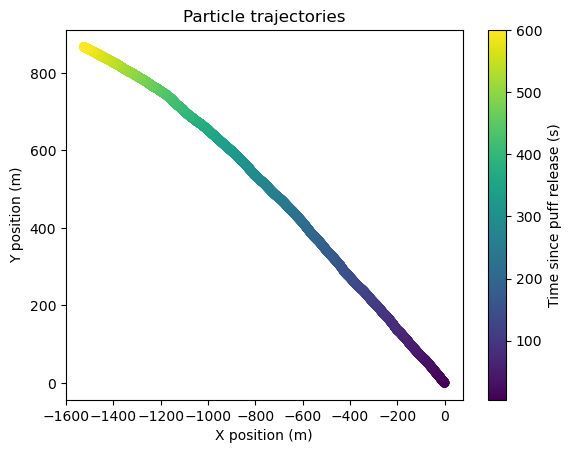

In [9]:
duration = 600  # seconds
dt = 5  # seconds
# remove the average wind speed to get more curvature
# in the particle trajectory while developing this method
u = df["u"].values[: duration // dt]
v = df["v"].values[: duration // dt]
print("Mean wind speed: ", np.mean(np.sqrt(u**2 + v**2)))
times = np.arange(1, len(u) + 1) * dt
times, x, y = compute_positions(times, u, v, dt_interp=0.1)
plt.scatter(x, y, c=times, cmap="viridis")
plt.colorbar(label="Time since puff release (s)")

plt.xlabel("X position (m)")
plt.ylabel("Y position (m)")
plt.title("Particle trajectories")

Time taken: 52 ms


Text(0.5, 1.0, 'Ornstein-Uhlenbeck disturbance')

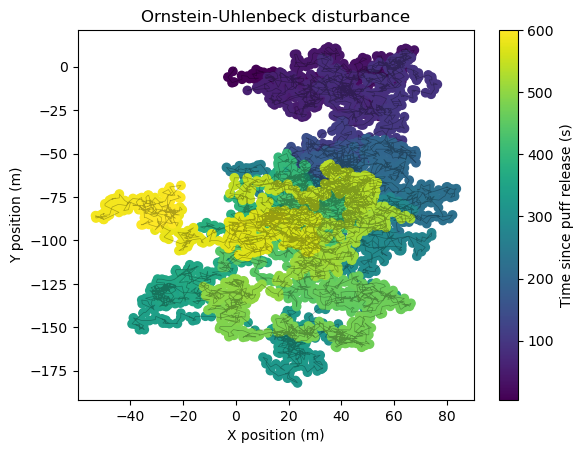

In [10]:
dt_interp = times[1] - times[0]
_start = time.time()
x_disturbance, y_disturbance = simulate_OU_2D(
    n_steps=len(times),
    dt=dt_interp,
    sigma_fluctuations=20.0,  # m/s
    correlation_time=120.0,
)
_end = time.time()
print(f"Time taken: {int((_end - _start) * 1000)} ms")
plt.plot(x_disturbance, y_disturbance, "-", color="black", alpha=0.3, linewidth=0.5)
plt.scatter(x_disturbance[1:], y_disturbance[1:], c=times, cmap="viridis")
plt.colorbar(label="Time since puff release (s)")
plt.xlabel("X position (m)")
plt.ylabel("Y position (m)")
plt.title("Ornstein-Uhlenbeck disturbance")

Text(0.5, 1.0, 'Particle trajectories with Ornstein-Uhlenbeck disturbance')

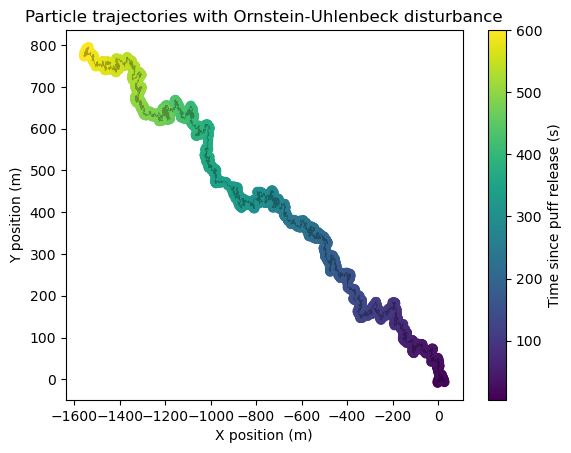

In [11]:
plt.plot(x + x_disturbance[1:], y + y_disturbance[1:], "-", color="black", alpha=0.3, linewidth=0.5)
plt.scatter(x + x_disturbance[1:], y + y_disturbance[1:], c=times, cmap="viridis")
plt.colorbar(label="Time since puff release (s)")
plt.xlabel("X position (m)")
plt.ylabel("Y position (m)")
plt.title("Particle trajectories with Ornstein-Uhlenbeck disturbance")

In [12]:
%%time
# Create concentration field
pixel_size = 4.0
raster_size = int(round(128 * 20 / pixel_size))  # covers 128x128 Sentinel 2 chip
concentration, X, Y = create_concentration_field(
    x,
    y,
    times,
    pixel_size=pixel_size,
    emission_rate=1000.0,
    raster_size=raster_size,
    dispersion_coeff=0.6,
)
concentration_disturbed, X, Y = create_concentration_field(
    x + x_disturbance[:-1],
    y + y_disturbance[:-1],
    times,
    pixel_size=pixel_size,
    emission_rate=1000.0,
    raster_size=raster_size,
    dispersion_coeff=0.6,
)

CPU times: user 2.22 s, sys: 23.5 ms, total: 2.24 s
Wall time: 2.24 s


In [13]:
# sanity check on the IME
# 57.75286 is the conversion factor from mol/s to kg/hr for CH₄, given:
#    1 mol CH₄/s = 16.04246 g/s ≈ 0.01604 kg/s = 57.75 kg/hr.
# expected IME is 1000 kg/hr / 57.75 (kg.hr⁻¹.mol⁻¹.s) * 600 s = 10400 mol
concentration.sum() * pixel_size**2, concentration_disturbed.sum() * pixel_size**2
# (10303.357238945426, 10301.559358064691) with a 256 pixel raster
# (8232.002239504789, 8186.738554419864) with a 128 pixel raster (some methane ends up outside the raster)

(8232.002239504789, 8365.078510295612)

(-500.0, 500.0)

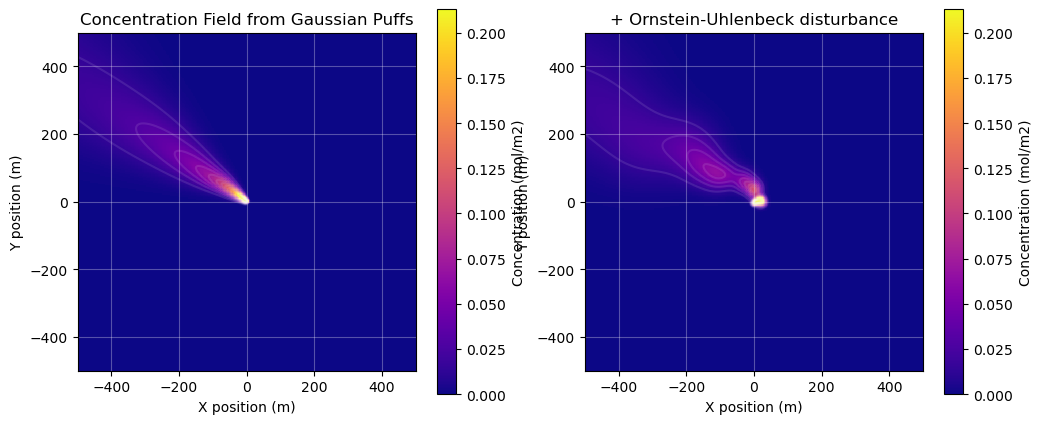

In [14]:
# Plot the result
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(
    concentration,
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    vmin=0.0,
    vmax=concentration.max() / 2,
    interpolation="nearest",
    origin="lower",
    cmap="plasma",
    aspect="equal",
)
plt.colorbar(label="Concentration (mol/m2)")
plt.contour(
    X, Y, concentration, colors="white", alpha=0.1, levels=np.linspace(concentration.min(), concentration.max(), 30)
)
plt.xlabel("X position (m)")
plt.ylabel("Y position (m)")
plt.title("Concentration Field from Gaussian Puffs")
plt.grid(True, color="white", alpha=0.3)
plt.xlim(-500, 500)
plt.ylim(-500, 500)

plt.subplot(1, 2, 2)
plt.imshow(
    concentration_disturbed,
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    vmin=0.0,
    vmax=concentration.max() / 2,
    interpolation="nearest",
    origin="lower",
    cmap="plasma",
    aspect="equal",
)
plt.colorbar(label="Concentration (mol/m2)")
plt.contour(
    X,
    Y,
    concentration_disturbed,
    colors="white",
    alpha=0.1,
    levels=np.linspace(concentration.min(), concentration.max(), 30),
)
plt.xlabel("X position (m)")
plt.ylabel("Y position (m)")
plt.title("+ Ornstein-Uhlenbeck disturbance")
plt.grid(True, color="white", alpha=0.3)
plt.xlim(-500, 500)
plt.ylim(-500, 500)

# Guidance from the Gorroño plumes

/anaconda/envs/methane-cv-4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found the config file in: /config.json


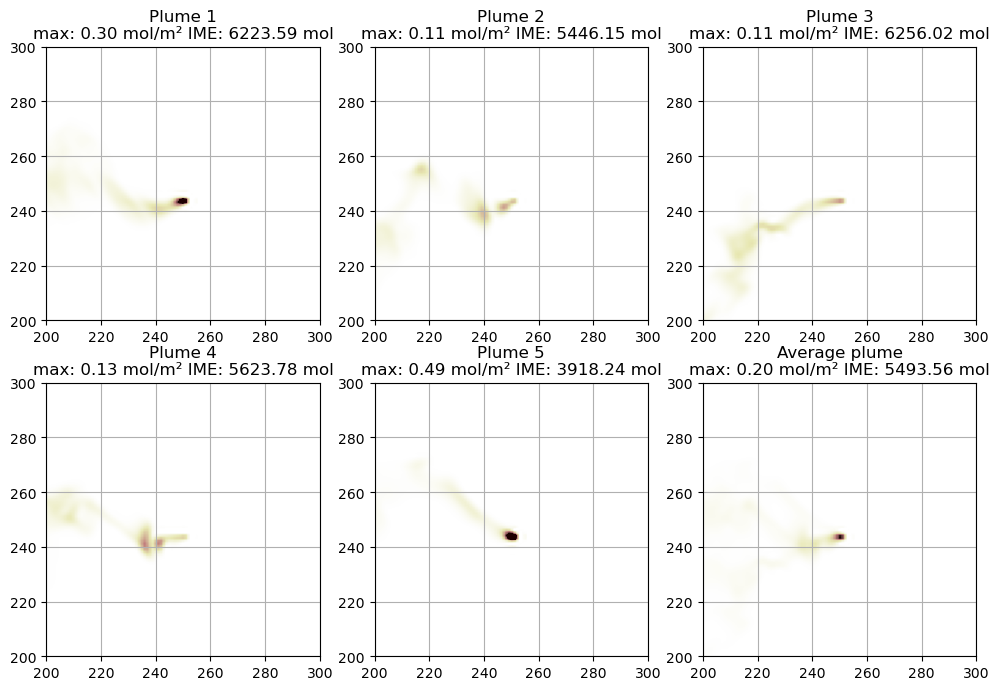

In [15]:
# from src.validation.fpr_dt_pipeline import load_gorrono_plumes
import tempfile
from pathlib import Path

from src.azure_wrap.blob_storage_sdk_v2 import download_from_blob
from src.azure_wrap.ml_client_utils import (
    get_azureml_uri,
    initialize_blob_service_client,
    make_acceptable_uri,
)
from src.utils.utils import initialize_clients

ml_client, _, _, s3_client = initialize_clients(False)
abs_client = initialize_blob_service_client(ml_client)


def load_gorrono_plumes(ml_client) -> list[np.ndarray]:
    """Download Gorroño plumes to a temporary directory, convert them to mol/m² and return their paths."""
    with tempfile.TemporaryDirectory() as temp_dir:
        temp_path = Path(temp_dir)
        gorrono_plumes_uri = make_acceptable_uri(
            str(get_azureml_uri(ml_client, "orbio-data/methane_enhancements_molpercm2"))
        )
        download_from_blob(gorrono_plumes_uri, temp_path, recursive=True)

        # We need to convert the enhancements from mol/cm² to mol/m² as the radtran functions expect mol/m²
        raw_enhancements = [np.load(temp_path / f"{i}/methane_enhancement.npy") * 1e4 for i in range(5)]

    return raw_enhancements


gorrono_plumes = load_gorrono_plumes(ml_client)
gorrono_wind_speed = 3.5  # all Gorroño simulations were run with 3.5 m/s wind speed

# Plot the plumes
plt.figure(figsize=(12, 8))
for i, plume in enumerate(gorrono_plumes):
    plt.subplot(2, 3, i + 1)
    plt.imshow(plume, cmap="pink_r", vmin=0, vmax=0.2)
    plt.title(f"Plume {i+1}\nmax: {plume.max():.2f} mol/m² IME: {plume.sum()*20*20:.2f} mol")
    plt.xlim(200, 300)
    plt.ylim(200, 300)
    plt.grid()
plt.subplot(2, 3, 6)
# plot the average Gorrono plume
mean_plume = np.mean(gorrono_plumes, axis=0)
plt.imshow(mean_plume, cmap="pink_r", vmin=0, vmax=0.2)
plt.title(f"Average plume\nmax: {mean_plume.max():.2f} mol/m² IME: {mean_plume.sum()*20*20:.2f} mol")
plt.xlim(200, 300)
plt.ylim(200, 300)
plt.grid()

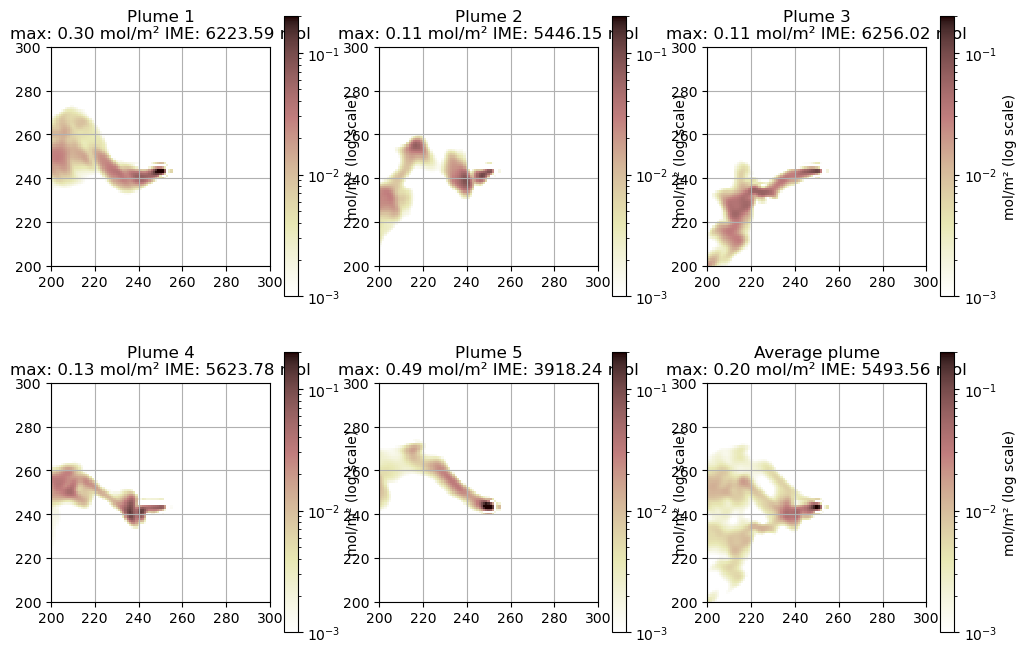

In [16]:
# same thing on a logarithmic scale
import matplotlib

plt.figure(figsize=(12, 8))
cmap_norm = matplotlib.colors.LogNorm(vmin=0.001, vmax=0.2)  # log scale for the colorbar
for i, plume in enumerate(gorrono_plumes):
    plt.subplot(2, 3, i + 1)
    plt.imshow(plume, cmap="pink_r", interpolation="nearest", norm=cmap_norm)
    plt.title(f"Plume {i+1}\nmax: {plume.max():.2f} mol/m² IME: {plume.sum()*20*20:.2f} mol")
    plt.xlim(200, 300)
    plt.ylim(200, 300)
    plt.grid()
    plt.colorbar(label="mol/m² (log scale)")
plt.subplot(2, 3, 6)
# plot the average Gorrono plume
mean_plume = np.mean(gorrono_plumes, axis=0)
im = plt.imshow(mean_plume, cmap="pink_r", interpolation="nearest", norm=cmap_norm)
plt.title(f"Average plume\nmax: {mean_plume.max():.2f} mol/m² IME: {mean_plume.sum()*20*20:.2f} mol")
plt.xlim(200, 300)
plt.ylim(200, 300)
plt.grid()
plt.colorbar(im, label="mol/m² (log scale)")

## Parametrization using Gorrono plumes

There are two parameters we need to choose for the stochastic Gaussian puffs:
- dispersion coefficient (m/s)
- Ornstein-Uhlenbeck noise parameter (`sigma_fluctuations`)

### Dispersion coefficient


In [17]:
def calculate_plume_width_profile(
    plume_data: np.ndarray,
    pixel_size: float,
    window_size: int,
    percentile_low: float = 0.1,
    percentile_high: float = 0.9,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculates the plume width profile using a sliding window approach.

    The width is defined as the distance between the specified lower and upper
    percentiles of the cumulative concentration in a vertical cross-section,
    averaged over the window.

    Args:
        plume_data: 2D numpy array of plume concentration data.
        pixel_size: The size of each pixel in meters.
        window_size: The number of pixels to average over for each width calculation (sliding window width).
        percentile_low: The lower percentile for width calculation (e.g., 0.1 for 10th).
        percentile_high: The upper percentile for width calculation (e.g., 0.9 for 90th).

    Returns
    -------
        A tuple containing:
            - x_centers_np: 1D numpy array of x-coordinates (pixel index) for the center of each window.
            - widths_m_np: 1D numpy array of calculated plume widths in meters for each window.
    """
    num_rows, num_cols = plume_data.shape
    widths_m = []  # To store width in meters for each window
    x_centers = []  # To store the center x-pixel index of each window

    # Y-coordinates (pixel indices) for interpolation
    y_pixel_indices = np.arange(num_rows)

    # Iterate with a moving window
    for x_start_idx in range(num_cols - window_size + 1):
        # Extract the current window_size wide slice
        current_window_slice = plume_data[:, x_start_idx : x_start_idx + window_size]
        # Average the data across the window_size pixels in the window to get a single vertical profile
        averaged_col_data = current_window_slice.mean(axis=1)

        current_x_center = x_start_idx + (window_size - 1) / 2.0
        x_centers.append(current_x_center)

        # If the averaged column sum is negligible, width is zero
        if averaged_col_data.sum() < 1e-9:
            widths_m.append(0.0)
            continue

        cum_sum = np.cumsum(averaged_col_data)

        # Avoid division by zero if somehow sum is positive but last element of cum_sum is zero
        if cum_sum[-1] == 0:
            widths_m.append(0.0)
            continue

        norm_cum_sum = cum_sum / cum_sum[-1]  # Normalize to [0, 1]

        # Interpolate to find y-pixel positions for the specified percentiles
        y_at_p_low = np.interp(percentile_low, norm_cum_sum, y_pixel_indices)
        y_at_p_high = np.interp(percentile_high, norm_cum_sum, y_pixel_indices)

        width_in_pixels = y_at_p_high - y_at_p_low
        widths_m.append(width_in_pixels * pixel_size)  # Convert width to meters

    return np.array(x_centers), np.array(widths_m)

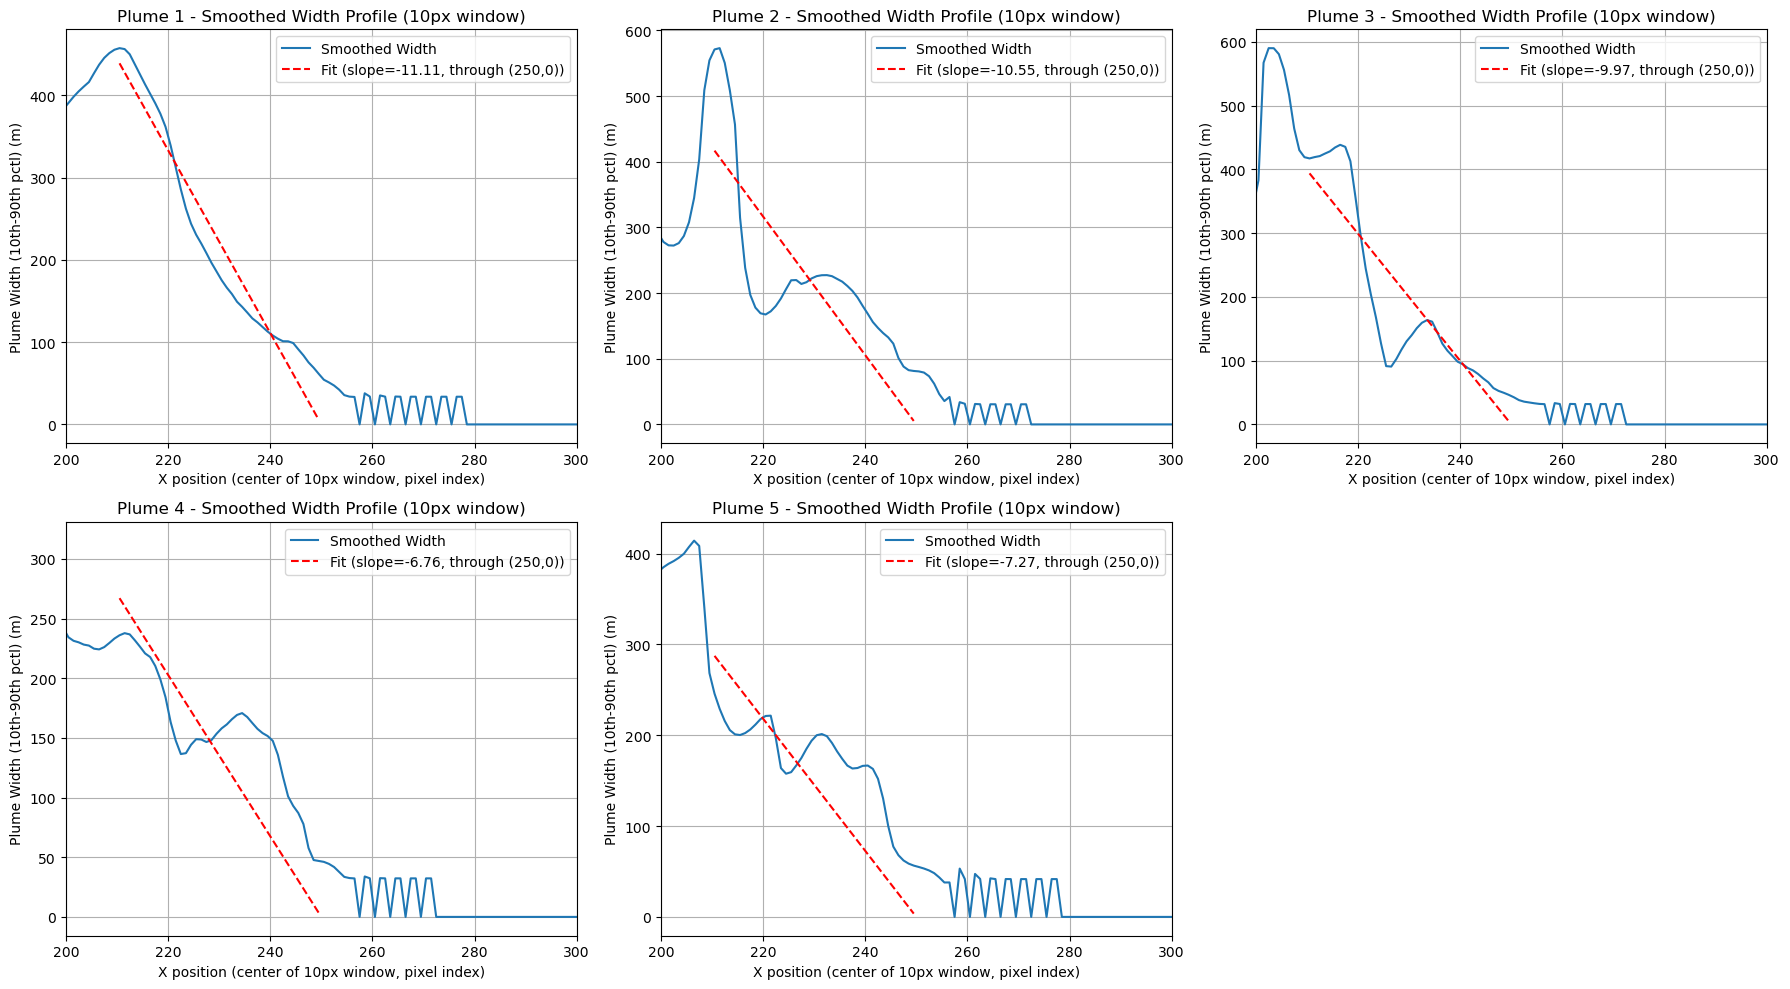


Average slopes in the x-range [210, 250] (fit through (250,0)):
Plume 1: -11.11 m/pixel
Plume 2: -10.55 m/pixel
Plume 3: -9.97 m/pixel
Plume 4: -6.76 m/pixel
Plume 5: -7.27 m/pixel
Mean slope:  -9.133775030943712


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats  # Import scipy.stats for linear regression

# Assuming gorrono_plumes is loaded from the previous cell (in[12])
# and pixel_size is known from the Gorrono dataset context.
pixel_size = 20.0  # meters per pixel for Gorrono plumes
window_size = 10  # Number of pixels to average over for each width calculation

plt.figure(figsize=(18, 10))  # Adjusted for better subplot spacing
plume_slopes = []

for i, plume_data in enumerate(gorrono_plumes):
    # Calculate plume width profile using the new helper function
    x_centers_np, widths_m_np = calculate_plume_width_profile(
        plume_data,
        pixel_size=pixel_size,  # Gorrono pixel_size
        window_size=window_size,
    )

    # --- Calculate average slope in the range 210 to 250, with line passing through (250,0) ---
    slope_range_mask = (x_centers_np >= 210) & (x_centers_np <= 250)
    x_in_range = x_centers_np[slope_range_mask]
    widths_in_range = widths_m_np[slope_range_mask]

    current_slope = np.nan
    line_fit_y = np.array([])  # Initialize for plotting

    if len(x_in_range) > 0:  # Need at least one point in the range
        x0 = 250.0  # The x-coordinate the line must pass through with y=0
        x_prime = x_in_range - x0  # x_i - 250

        numerator = np.sum(x_prime * widths_in_range)  # sum((x_i-250)*y_i)
        denominator = np.sum(x_prime**2)  # sum((x_i-250)^2)

        if denominator > 1e-9:  # Avoid division by zero or unstable fit
            current_slope = numerator / denominator
            # Calculate y-values for the fitted line: y = m*(x - x0)
            line_fit_y = current_slope * (x_in_range - x0)
        # If denominator is ~0, it means all x_in_range points are ~x0.
        # current_slope remains np.nan in this case.

    plume_slopes.append(current_slope)  # Appends the calculated slope or np.nan
    # --- End of slope calculation ---

    plt.subplot(2, 3, i + 1)
    plt.plot(x_centers_np, widths_m_np, label="Smoothed Width")
    if not np.isnan(current_slope) and len(x_in_range) > 0:
        plt.plot(x_in_range, line_fit_y, "r--", label=f"Fit (slope={current_slope:.2f}, through (250,0))")
    plt.title(f"Plume {i+1} - Smoothed Width Profile (10px window)")
    plt.xlabel("X position (center of 10px window, pixel index)")
    plt.ylabel("Plume Width (10th-90th pctl) (m)")
    plt.grid(True)
    plt.xlim(200, 300)  # Match x-axis of Gorrono plume plots
    plt.legend()
    # You might want to adjust ylim if widths vary greatly
    # plt.ylim(0, max(widths_m_np, default=100) * 1.1)


plt.tight_layout()
plt.show()

print("\nAverage slopes in the x-range [210, 250] (fit through (250,0)):")
for i, slope_val in enumerate(plume_slopes):
    print(f"Plume {i+1}: {slope_val:.2f} m/pixel")
print("Mean slope: ", np.mean(plume_slopes))

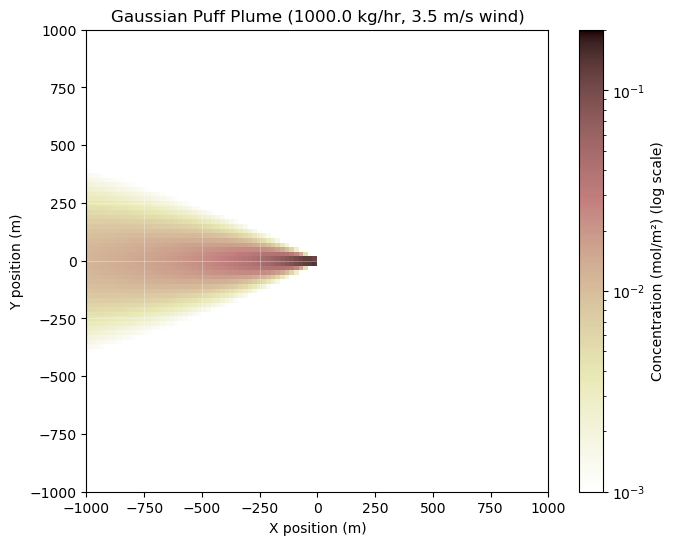

In [19]:
# Parameters
duration = 600  # seconds
dt_interp = 0.1  # seconds for position interpolation
wind_speed = 3.5  # m/s
emission_rate = 1000.0  # kg/hr
pixel_size = 20  # meters
raster_size = int(100 * 20 / pixel_size)  # pixels
dispersion_coeff = 0.6  # m/s

# Create time and velocity arrays
times_wind = np.array([0, duration])
u = np.ones(2) * -wind_speed  # Westward wind
v = np.zeros(2)

# Compute puff positions
times_gaussian, x_gaussian, y_gaussian = compute_positions(times_wind, u, v, dt_interp=dt_interp)

# Create concentration field
concentration_gaussian, X_gauss, Y_gauss = create_concentration_field(
    x_gaussian,
    y_gaussian,
    times_gaussian,
    pixel_size=pixel_size,
    emission_rate=emission_rate,
    raster_size=raster_size,
    dispersion_coeff=dispersion_coeff,
)

# Plot the result with log scale
plt.figure(figsize=(8, 6))
# Determine appropriate vmin for log scale (avoiding zero or negative)
im = plt.imshow(
    concentration_gaussian,
    extent=[X_gauss.min(), X_gauss.max(), Y_gauss.min(), Y_gauss.max()],
    norm=cmap_norm,
    interpolation="nearest",
    origin="lower",
    cmap="pink_r",
    aspect="equal",
)
plt.colorbar(im, label="Concentration (mol/m²) (log scale)")
plt.xlabel("X position (m)")
plt.ylabel("Y position (m)")
plt.title(f"Gaussian Puff Plume ({emission_rate} kg/hr, {wind_speed} m/s wind)")
plt.grid(True, color="white", alpha=0.3)
# Optional: Adjust limits if needed
# plt.xlim(-50*pixel_size, 50*pixel_size)
# plt.ylim(-50*pixel_size, 50*pixel_size)
plt.show()

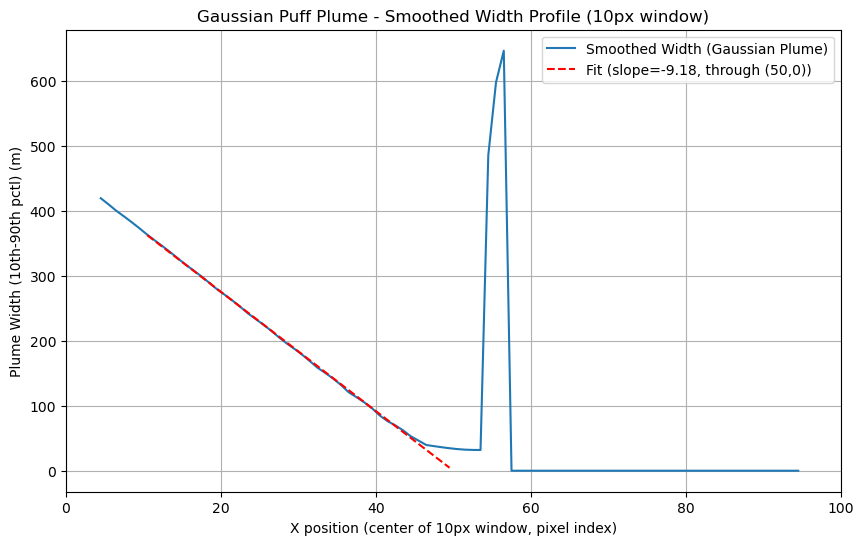


Gaussian Plume: Average slope in the x-range [10, 50] (fit through (50,0)): -9.18 m/pixel


In [20]:
# Use the pixel_size specific to the Gaussian plume simulation
pixel_size_gaussian = pixel_size  # from in[15]
# raster_size_gaussian = raster_size # from in[15] # Not directly needed here anymore for width calculation

plume_data_gaussian = concentration_gaussian
# num_rows_g, num_cols_g = plume_data_gaussian.shape # Handled by the function
# widths_m_gaussian = [] # Handled by the function
# x_centers_gaussian = [] # Handled by the function

# y_pixel_indices_g = np.arange(num_rows_g) # Handled by the function
window_size = 10  # Same window size as Gorrono analysis

# Calculate plume width profile using the new helper function
x_centers_gaussian_np, widths_m_gaussian_np = calculate_plume_width_profile(
    plume_data_gaussian, pixel_size=pixel_size_gaussian, window_size=window_size
)

# --- Calculate slope for Gaussian plume, fit through (source_pixel_x, 0) ---
# Source is at the center of the X_gauss grid. The number of columns is needed for this.
_, num_cols_g = plume_data_gaussian.shape  # Get num_cols for x0_pixel_gaussian
x0_pixel_gaussian = num_cols_g // 2

# Define the range for slope calculation (40 pixels before the source)
slope_range_min_g = x0_pixel_gaussian - 40
slope_range_max_g = x0_pixel_gaussian

slope_range_mask_g = (x_centers_gaussian_np >= slope_range_min_g) & (x_centers_gaussian_np <= slope_range_max_g)
x_in_range_g = x_centers_gaussian_np[slope_range_mask_g]
widths_in_range_g = widths_m_gaussian_np[slope_range_mask_g]

slope_gaussian = np.nan
line_fit_y_g = np.array([])

if len(x_in_range_g) > 0:
    x_prime_g = x_in_range_g - x0_pixel_gaussian
    numerator_g = np.sum(x_prime_g * widths_in_range_g)
    denominator_g = np.sum(x_prime_g**2)
    if denominator_g > 1e-9:
        slope_gaussian = numerator_g / denominator_g
        line_fit_y_g = slope_gaussian * (x_in_range_g - x0_pixel_gaussian)

# --- Plotting for Gaussian Plume ---
plt.figure(figsize=(10, 6))
plt.plot(x_centers_gaussian_np, widths_m_gaussian_np, label="Smoothed Width (Gaussian Plume)")
if not np.isnan(slope_gaussian) and len(x_in_range_g) > 0:
    plt.plot(
        x_in_range_g, line_fit_y_g, "r--", label=f"Fit (slope={slope_gaussian:.2f}, through ({x0_pixel_gaussian},0))"
    )

plt.title("Gaussian Puff Plume - Smoothed Width Profile (10px window)")
plt.xlabel("X position (center of 10px window, pixel index)")
plt.ylabel("Plume Width (10th-90th pctl) (m)")
plt.grid(True)
# Adjust xlim to focus on the plume area, source is at num_cols_g // 2
plt.xlim(0, num_cols_g)
plt.legend()
plt.show()

print(
    f"\nGaussian Plume: Average slope in the x-range [{slope_range_min_g}, {slope_range_max_g}] (fit through ({x0_pixel_gaussian},0)): {slope_gaussian:.2f} m/pixel"
)

### sigma_fluctuations

In [21]:
# --- Calculate 2D Earth Mover's Distance (Wasserstein Distance) between Gorrono and Gaussian plumes ---
import ot  # Optimal Transport library


def calculate_wasserstein_distance(plume1: np.ndarray, plume2: np.ndarray) -> float:
    """
    Calculate the 2D Wasserstein-2 Distance (Earth Mover's Distance) between two plume images.

    This function computes the Wasserstein-2 distance between two 2D plume distributions,
    treating them as probability distributions. The plumes should have the same dimensions.

    Args:
        plume1: First plume image as a 2D numpy array
        plume2: Second plume image as a 2D numpy array with same shape as plume1

    Returns
    -------
        float: The Wasserstein-2 distance between the two plume distributions

    Note:
        The function normalizes the plumes to create proper probability distributions,
        constructs a cost matrix based on the spatial coordinates, and uses optimal
        transport to compute the distance.
    """
    if plume1.shape != plume2.shape:
        raise ValueError(f"Plume shapes must match! Got {plume1.shape} and {plume2.shape}")
    # Normalize plumes to create probability distributions
    plume1_flat = plume1.flatten().clip(min=0.0)
    plume2_flat = plume2.flatten().clip(min=0.0)
    # This check should ideally be done by the caller, but as a safeguard:
    if np.sum(plume1_flat) <= 1e-9 or np.sum(plume2_flat) <= 1e-9:
        # If either plume is essentially empty, EMD might be ill-defined or very large.
        raise ValueError("Cannot calculate Wasserstein distance: one or both plumes have near-zero sum.")
    a = plume1_flat / np.sum(plume1_flat)
    b = plume2_flat / np.sum(plume2_flat)
    # Ensure a and b are also float64 and C-contiguous
    a = np.ascontiguousarray(a, dtype=np.float64)
    b = np.ascontiguousarray(b, dtype=np.float64)

    # Create coordinate grids
    h, w = plume1.shape
    y_grid, x_grid = np.mgrid[0:h, 0:w]
    coords = np.column_stack((y_grid.flatten(), x_grid.flatten()))

    # Compute the cost matrix (squared Euclidean distance)
    M = ot.dist(coords, coords, metric="sqeuclidean")

    # Calculate the Earth Mover's Distance
    emd_2d = ot.emd2(a, b, M, numThreads="max")
    return np.sqrt(emd_2d)  # Get the actual Wasserstein-2 distance


# Apply the function to compare Gorrono and Gaussian plumes
gorrono_emd_list = []
for i, plume in enumerate(gorrono_plumes):
    cropped_plume = plume[210:290, 200:260]
    cropped_gaussian = plume_data_gaussian[10:90, 0:60]
    assert cropped_plume.shape == cropped_gaussian.shape, "Gorrono and Gaussian plumes must have the same dimensions"
    emd_2d = calculate_wasserstein_distance(cropped_plume, cropped_gaussian)
    print(f"\n2D Earth Mover's Distance between Gorrono plume {i+1} and Gaussian plume: {emd_2d:.8f}")
    gorrono_emd_list.append(emd_2d)

print("Mean EMD for Gorrono plumes: ", np.mean(gorrono_emd_list))

/anaconda/envs/methane-cv-4/lib/python3.10/site-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)



2D Earth Mover's Distance between Gorrono plume 1 and Gaussian plume: 7.39615073

2D Earth Mover's Distance between Gorrono plume 2 and Gaussian plume: 11.23146133

2D Earth Mover's Distance between Gorrono plume 3 and Gaussian plume: 21.27046706

2D Earth Mover's Distance between Gorrono plume 4 and Gaussian plume: 7.34041643

2D Earth Mover's Distance between Gorrono plume 5 and Gaussian plume: 15.72714731
Mean EMD for Gorrono plumes:  12.59312857088327



Sigma fluctuations: 1.0


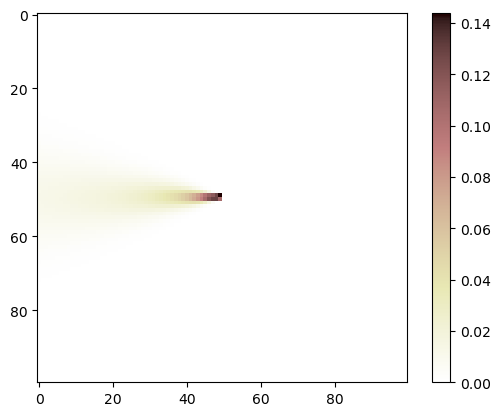

Sum of cropped disturbed Gaussian:  12.858642088589548
Sum of cropped Gaussian:  12.890448154516806

2D Earth Mover's Distance between disturbed Gaussian plume and Gaussian plume: 0.39962570

Sigma fluctuations: 2.0


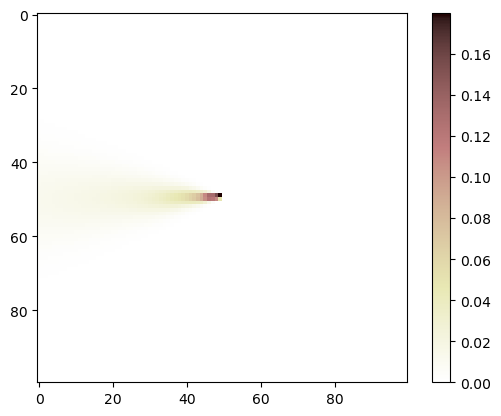

Sum of cropped disturbed Gaussian:  12.91105117981482
Sum of cropped Gaussian:  12.890448154516806

2D Earth Mover's Distance between disturbed Gaussian plume and Gaussian plume: 0.59955054

Sigma fluctuations: 5.0


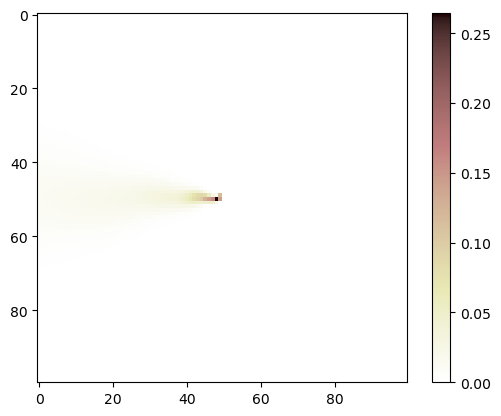

Sum of cropped disturbed Gaussian:  12.680050002948663
Sum of cropped Gaussian:  12.890448154516806

2D Earth Mover's Distance between disturbed Gaussian plume and Gaussian plume: 0.80486810

Sigma fluctuations: 10.0


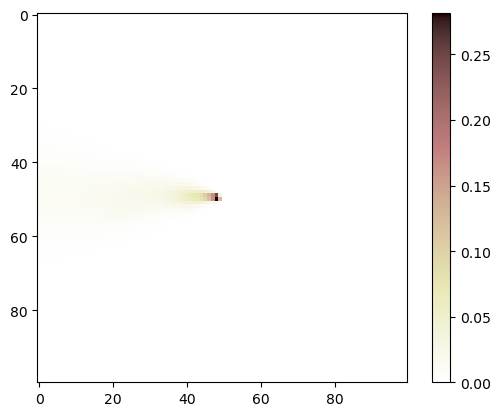

Sum of cropped disturbed Gaussian:  12.576759152202637
Sum of cropped Gaussian:  12.890448154516806

2D Earth Mover's Distance between disturbed Gaussian plume and Gaussian plume: 1.86930014

Sigma fluctuations: 20.0


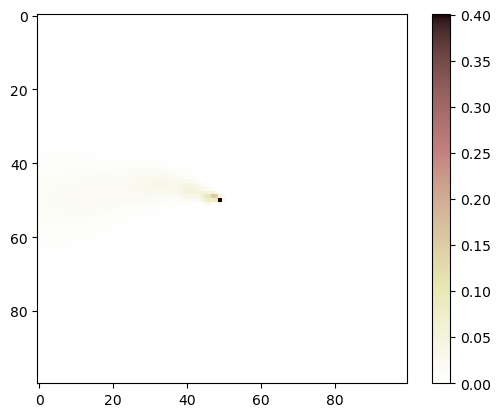

Sum of cropped disturbed Gaussian:  13.104473023700777
Sum of cropped Gaussian:  12.890448154516806

2D Earth Mover's Distance between disturbed Gaussian plume and Gaussian plume: 2.24752470

Sigma fluctuations: 30.0


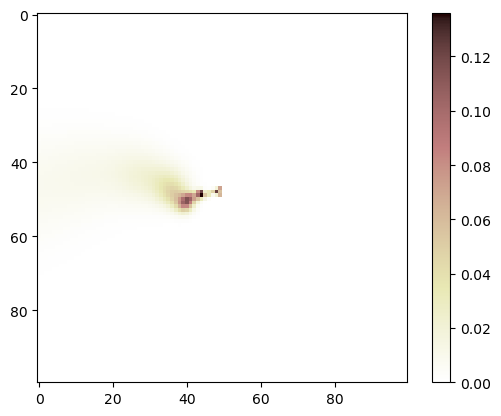

Sum of cropped disturbed Gaussian:  13.25211744472282
Sum of cropped Gaussian:  12.890448154516806

2D Earth Mover's Distance between disturbed Gaussian plume and Gaussian plume: 5.51868257

Sigma fluctuations: 40.0


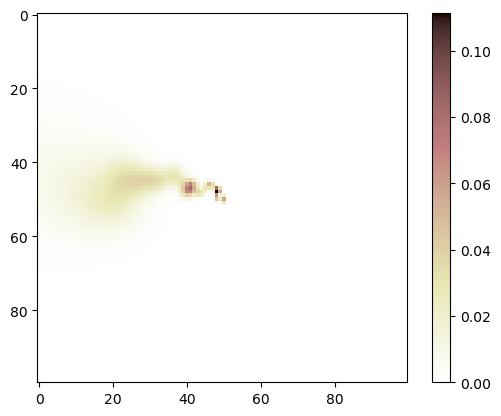

Sum of cropped disturbed Gaussian:  15.596052400714111
Sum of cropped Gaussian:  12.890448154516806

2D Earth Mover's Distance between disturbed Gaussian plume and Gaussian plume: 4.55706856

Sigma fluctuations: 50.0


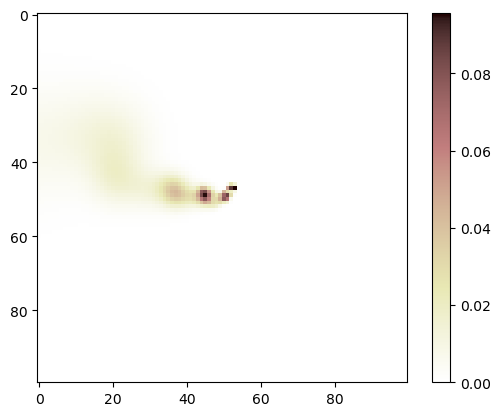

Sum of cropped disturbed Gaussian:  14.314251771931861
Sum of cropped Gaussian:  12.890448154516806

2D Earth Mover's Distance between disturbed Gaussian plume and Gaussian plume: 10.42216494

Sigma fluctuations: 100.0


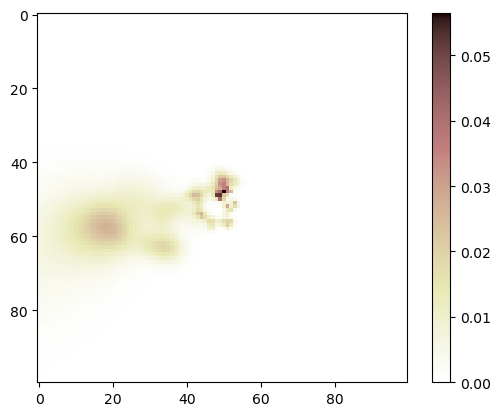

Sum of cropped disturbed Gaussian:  13.770211413006704
Sum of cropped Gaussian:  12.890448154516806

2D Earth Mover's Distance between disturbed Gaussian plume and Gaussian plume: 8.68373331


In [22]:
sigma_fluctuations_list = [1.0, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 100.0]
earth_mover_distances = []
for sigma in sigma_fluctuations_list:
    print(f"\nSigma fluctuations: {sigma}")
    x_disturbance, y_disturbance = simulate_OU_2D(
        n_steps=len(times_gaussian),
        dt=times_gaussian[1] - times_gaussian[0],
        sigma_fluctuations=sigma,  # m/s
        correlation_time=220.0,
    )
    x_disturbed = x_gaussian + x_disturbance[0 : len(x_gaussian)]
    y_disturbed = y_gaussian + y_disturbance[0 : len(y_gaussian)]

    pixel_size = 20.0  # meters
    raster_size = int(100 * 20 / pixel_size)  # pixels
    dispersion_coeff = 0.6  # m/s

    concentration_disturbed_gaussian, X_gauss, Y_gauss = create_concentration_field(
        x_disturbed,
        y_disturbed,
        times_gaussian,
        pixel_size=pixel_size,
        emission_rate=emission_rate,
        raster_size=raster_size,
        dispersion_coeff=dispersion_coeff,
    )
    plt.imshow(concentration_disturbed_gaussian, interpolation="nearest", cmap="pink_r")
    plt.colorbar()
    plt.show()

    cropped_disturbed_gaussian = concentration_disturbed_gaussian[10:90, 0:60]
    cropped_gaussian = concentration_gaussian[10:90, 0:60]
    assert (
        cropped_disturbed_gaussian.shape == cropped_gaussian.shape
    ), "Disturbed Gaussian and Gaussian plumes must have the same dimensions"
    emd_2d = calculate_wasserstein_distance(cropped_disturbed_gaussian, cropped_gaussian)
    print("Sum of cropped disturbed Gaussian: ", np.sum(cropped_disturbed_gaussian))
    print("Sum of cropped Gaussian: ", np.sum(cropped_gaussian))
    print(f"\n2D Earth Mover's Distance between disturbed Gaussian plume and Gaussian plume: {emd_2d:.8f}")
    earth_mover_distances.append(emd_2d)

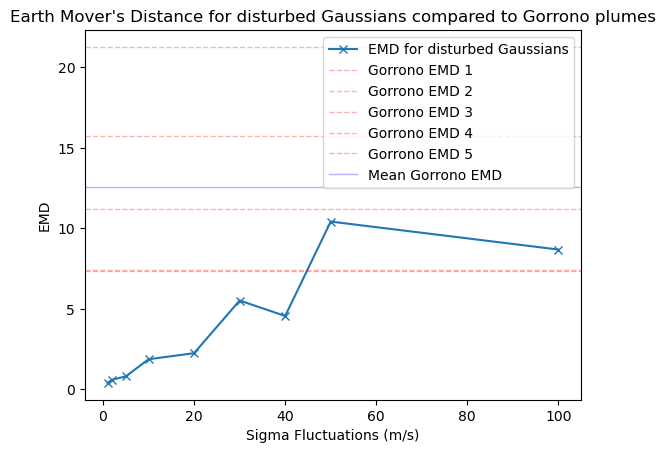

In [23]:
plt.plot(sigma_fluctuations_list, earth_mover_distances, "-x", label="EMD for disturbed Gaussians")
plt.xlabel("Sigma Fluctuations (m/s)")
plt.ylabel("EMD")
plt.title("Earth Mover's Distance for disturbed Gaussians compared to Gorrono plumes")
for i, emd in enumerate(gorrono_emd_list):
    plt.axhline(emd, color="red", linewidth=1, linestyle="--", alpha=0.3, label=f"Gorrono EMD {i+1}")
plt.axhline(np.mean(gorrono_emd_list), color="blue", linewidth=1, linestyle="-", alpha=0.3, label="Mean Gorrono EMD")
plt.legend()